# GGR (Gross Gaming Revenue) - Exploratory Data Analysis

This notebook performs comprehensive EDA on the gaming analytics dataset to understand:
- GGR patterns and distributions
- Betting volume (stakes, payouts, bets)
- RTP (Return to Player) behavior
- Game type impacts
- Temporal patterns
- Train/Test split characteristics

In [1]:
import pandas as pd

In [2]:
# Load GGR timeseries data
df = pd.read_csv('warehouse/data/ggr_timeseries.csv', parse_dates=['date'])
print(f"Loaded {len(df)} rows")
df.head()

Loaded 343 rows


,date,GGR,num_operators,operators_list,num_reports,total_bets,total_stake,total_payout,modal_game_type,is_missing
0,2024-12-30,2.790238e+06,1,SAH,2,101,7.081448e+06,4.291210e+06,RRI_sports,0
1,2024-12-31,3.134494e+09,9,"ABA,BET,ELD,ENT,INT,MAS,RUB,SAH,TIT",11,1645245,4.463698e+09,1.329014e+09,RRI_sports,0
2,2025-01-01,1.324485e+09,10,"ABA,ABE,BET,ELD,ENT,INT,MAS,RUB,SAH,TIT",13,989808,2.864151e+09,1.539373e+09,RRI_sports,0
3,2025-01-02,6.896478e+08,10,"ABA,ABE,BET,ELD,ENT,INT,MAS,RUB,SAH,TIT",13,580974,1.865428e+09,1.175750e+09,RRI_sports,0
4,2025-01-03,3.416688e+08,10,"ABA,ABE,BET,ELD,ENT,INT,MAS,RUB,SAH,TIT",13,542616,1.882153e+09,1.540381e+09,RRI_sports,0


In [3]:
df['GGR'].corr(df['total_bets'])

np.float64(0.2483962744320753)

In [4]:
# Create time-shifted GGR (lag 6)
df['GGR_lag6'] = df['GGR'].shift(6)

# Check autocorrelation
autocorr_lag6 = df['GGR'].corr(df['GGR_lag6'])
print(f"Autocorrelation (GGR vs GGR_lag6): {autocorr_lag6:.4f}")

# Show the data
df[['date', 'GGR', 'GGR_lag6']].head(10)

Autocorrelation (GGR vs GGR_lag6): 0.2135


,date,GGR,GGR_lag6
0,2024-12-30,2.790238e+06,NaN
1,2024-12-31,3.134494e+09,NaN
2,2025-01-01,1.324485e+09,NaN
3,2025-01-02,6.896478e+08,NaN
4,2025-01-03,3.416688e+08,NaN
5,2025-01-04,1.054617e+09,NaN
6,2025-01-05,3.510391e+09,2.790238e+06
7,2025-01-06,6.485987e+08,3.134494e+09
8,2025-01-07,6.184232e+07,1.324485e+09
9,2025-01-08,7.379000e+08,6.896478e+08


In [5]:
# Check how well total_bets and GGR_lag6 together describe current GGR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Remove rows with NaN (from lagging)
df_clean = df[['GGR', 'total_bets', 'GGR_lag6']].dropna()

# Prepare features and target
X = df_clean[['total_bets', 'GGR_lag6']]
y = df_clean['GGR']

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Predictions and R²
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"Combined Model: total_bets + GGR_lag6 → GGR")
print(f"R² Score: {r2:.4f}")
print(f"\nCoefficients:")
print(f"  total_bets: {model.coef_[0]:.2f}")
print(f"  GGR_lag6: {model.coef_[1]:.4f}")
print(f"  Intercept: {model.intercept_:.2f}")

print(f"\nIndividual correlations:")
print(f"  GGR vs total_bets: {df['GGR'].corr(df['total_bets']):.4f}")
print(f"  GGR vs GGR_lag6: {autocorr_lag6:.4f}")

Combined Model: total_bets + GGR_lag6 → GGR
R² Score: 0.1081

Coefficients:
  total_bets: 988.14
  GGR_lag6: 0.2175
  Intercept: -534946543.85

Individual correlations:
  GGR vs total_bets: 0.2484
  GGR vs GGR_lag6: 0.2135


In [6]:
# Check for entries where total_bets == 0
zero_bets = df[df['total_bets'] == 0]
print(f"Number of entries with total_bets == 0: {len(zero_bets)}")
print("\nEntries with zero bets:")
print(zero_bets)

Number of entries with total_bets == 0: 0

Entries with zero bets:
Empty DataFrame
Columns: [date, GGR, num_operators, operators_list, num_reports, total_bets, total_stake, total_payout, modal_game_type, is_missing, GGR_lag6]
Index: []


In [7]:
# Add is_weekend column (1 for Saturday/Sunday, 0 for weekdays)
df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)

print(f"Weekend days: {df['is_weekend'].sum()}")
print(f"Weekday days: {(df['is_weekend'] == 0).sum()}")
df[['date', 'is_weekend']].head(10)

Weekend days: 98
Weekday days: 245


,date,is_weekend
0,2024-12-30,0
1,2024-12-31,0
2,2025-01-01,0
3,2025-01-02,0
4,2025-01-03,0
5,2025-01-04,1
6,2025-01-05,1
7,2025-01-06,0
8,2025-01-07,0
9,2025-01-08,0


In [ ]:
df['is_weekend_cat'] = df['is_weekend'].astype('category')

In [9]:
df['is_weekend_cat'] = df['is_weekend'].astype('category')

In [10]:
from statsmodels.formula.api import ols

In [12]:
model = ols('GGR ~ C(is_weekend_cat)', data=df[['GGR', 'is_weekend_cat']]).fit()

In [15]:
# Perform the ANOVA
import statsmodels.api as sm
anova_table = sm.stats.anova_lm(model, typ=2)

In [16]:
print(anova_table)

                         sum_sq     df         F    PR(>F)
C(is_weekend_cat)  5.150055e+19    1.0  9.033954  0.002847
Residual           1.943965e+21  341.0       NaN       NaN


In [ ]:
# Interpret the ANOVA results
print("ANOVA INTERPRETATION:")
print("="*60)

# Extract values
weekend_ss = anova_table.loc['C(is_weekend_cat)', 'sum_sq']
residual_ss = anova_table.loc['Residual', 'sum_sq']
total_ss = weekend_ss + residual_ss
f_stat = anova_table.loc['C(is_weekend_cat)', 'F']
p_value = anova_table.loc['C(is_weekend_cat)', 'PR(>F)']

# Calculate effect size (eta squared)
eta_squared = weekend_ss / total_ss

print(f"\n1. Statistical Significance:")
print(f"   F-statistic: {f_stat:.2f}")
print(f"   p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"   ✓ Weekend effect IS statistically significant (p < 0.05)")
else:
    print(f"   ✗ Weekend effect is NOT statistically significant (p >= 0.05)")

print(f"\n2. Effect Size (Eta Squared):")
print(f"   Weekend explains: {eta_squared*100:.2f}% of GGR variation")
print(f"   Unexplained: {(1-eta_squared)*100:.2f}% of GGR variation")

print(f"\n3. Interpretation:")
print(f"   - Weekends DO have a statistically significant effect on GGR")
print(f"   - However, the weekend factor explains only {eta_squared*100:.1f}% of variation")
print(f"   - {(1-eta_squared)*100:.1f}% of GGR variation is due to other factors")

# Show actual means
weekend_means = df.groupby('is_weekend')['GGR'].mean()
print(f"\n4. Actual GGR Means:")
print(f"   Weekday: {weekend_means[0]/1e9:.2f}B")
print(f"   Weekend: {weekend_means[1]/1e9:.2f}B")
print(f"   Weekend uplift: {(weekend_means[1]/weekend_means[0] - 1)*100:.1f}%")

In [17]:
df['total_stake'].corr(df['total_bets'])

np.float64(0.958142552491297)

Autocorrelation of total_bets with lagged values:
Lag 1: 0.3796
Lag 2: -0.0378
Lag 3: 0.1289
Lag 4: 0.1485
Lag 5: -0.0314
Lag 6: 0.2312
Lag 7: 0.6573


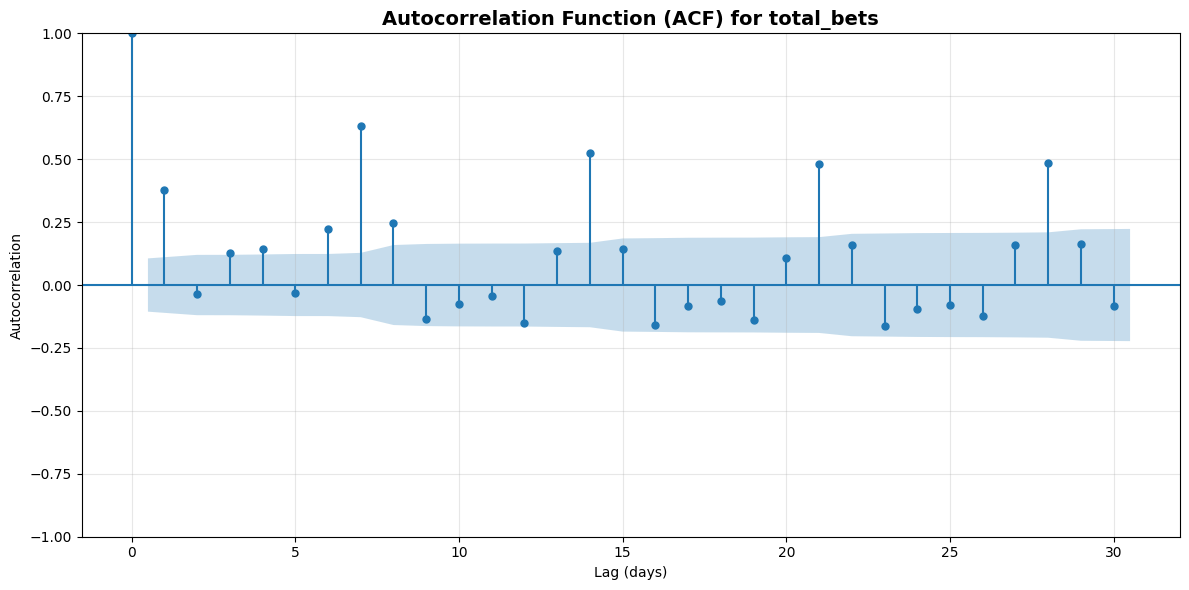

In [18]:
# Check ACF (Autocorrelation Function) for total_bets
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Calculate autocorrelation for different lags
print("Autocorrelation of total_bets with lagged values:")
print("="*50)
for lag in [1, 2, 3, 4, 5, 6, 7]:
    df[f'total_bets_lag{lag}'] = df['total_bets'].shift(lag)
    corr = df['total_bets'].corr(df[f'total_bets_lag{lag}'])
    print(f"Lag {lag}: {corr:.4f}")

# Plot ACF
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df['total_bets'].dropna(), lags=30, ax=ax)
ax.set_title('Autocorrelation Function (ACF) for total_bets', fontsize=14, fontweight='bold')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# Weekly pattern interpretation
print("WEEKLY PATTERN ANALYSIS:")
print("="*50)

# Check lag 7 specifically (weekly cycle)
lag7_corr = df['total_bets'].corr(df['total_bets_lag7'])
print(f"\nLag 7 (1 week) autocorrelation: {lag7_corr:.4f}")
print(f"\nInterpretation:")
print(f"  - Strong weekly cycle detected in betting volume")
print(f"  - Same day of week tends to have similar bet volumes")
print(f"  - This explains why weekends consistently show higher GGR")
print(f"  - Players have predictable weekly betting patterns")

# Compare different weekly multiples
print(f"\nWeekly cycle multiples:")
for week in [1, 2, 3, 4]:
    lag = week * 7
    if f'total_bets_lag{lag}' not in df.columns:
        df[f'total_bets_lag{lag}'] = df['total_bets'].shift(lag)
    corr = df['total_bets'].corr(df[f'total_bets_lag{lag}'])
    print(f"  {week} week(s) (lag {lag}): {corr:.4f}")

WEEKLY PATTERN ANALYSIS:

Lag 7 (1 week) autocorrelation: 0.6573

Interpretation:
  - Strong weekly cycle detected in betting volume
  - Same day of week tends to have similar bet volumes
  - This explains why weekends consistently show higher GGR
  - Players have predictable weekly betting patterns

Weekly cycle multiples:
  1 week(s) (lag 7): 0.6573
  2 week(s) (lag 14): 0.5684
  3 week(s) (lag 21): 0.5439
  4 week(s) (lag 28): 0.5510


REALIZED HOUSE EDGE ANALYSIS:

Basic Statistics:
  Mean: 0.2157 (21.57%)
  Median: 0.1948 (19.48%)
  Std Dev: 0.3592
  Min: -1.4389
  Max: 1.9806

Autocorrelation of realized_HE with lagged values:
Lag 1: 0.6623
Lag 2: 0.4859
Lag 3: 0.4566
Lag 4: 0.4109
Lag 5: 0.3407
Lag 6: 0.2933
Lag 7: 0.2426


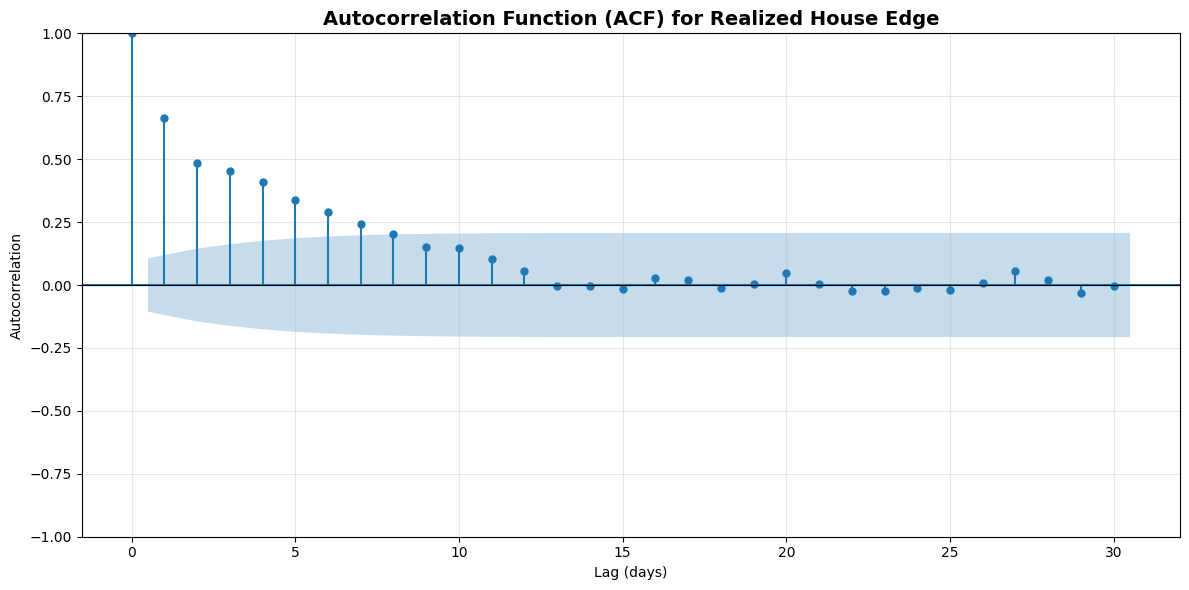

In [20]:
# Calculate Realized House Edge (RHE)
# RHE = GGR / total_stake (actual house edge realized in the data)
df['realized_HE'] = df['GGR'] / df['total_stake']

print("REALIZED HOUSE EDGE ANALYSIS:")
print("="*50)
print(f"\nBasic Statistics:")
print(f"  Mean: {df['realized_HE'].mean():.4f} ({df['realized_HE'].mean()*100:.2f}%)")
print(f"  Median: {df['realized_HE'].median():.4f} ({df['realized_HE'].median()*100:.2f}%)")
print(f"  Std Dev: {df['realized_HE'].std():.4f}")
print(f"  Min: {df['realized_HE'].min():.4f}")
print(f"  Max: {df['realized_HE'].max():.4f}")

# Check autocorrelation for realized house edge
print(f"\nAutocorrelation of realized_HE with lagged values:")
print("="*50)
for lag in [1, 2, 3, 4, 5, 6, 7]:
    df[f'realized_HE_lag{lag}'] = df['realized_HE'].shift(lag)
    corr = df['realized_HE'].corr(df[f'realized_HE_lag{lag}'])
    print(f"Lag {lag}: {corr:.4f}")

# Plot ACF for realized house edge
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df['realized_HE'].dropna(), lags=30, ax=ax)
ax.set_title('Autocorrelation Function (ACF) for Realized House Edge', fontsize=14, fontweight='bold')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# Test predictive power of lagged realized_HE (lags 1-4)
print("PREDICTING REALIZED HOUSE EDGE FROM ITS LAGS:")
print("="*60)

# Prepare data with lags 1-4
lag_cols = ['realized_HE_lag1', 'realized_HE_lag2', 'realized_HE_lag3', 'realized_HE_lag4']
df_rhe_clean = df[['realized_HE'] + lag_cols].dropna()

X_rhe = df_rhe_clean[lag_cols]
y_rhe = df_rhe_clean['realized_HE']

# Fit model
rhe_model = LinearRegression()
rhe_model.fit(X_rhe, y_rhe)
y_rhe_pred = rhe_model.predict(X_rhe)
r2_rhe = r2_score(y_rhe, y_rhe_pred)

print(f"\nModel: realized_HE_lag[1-4] → realized_HE")
print(f"R² Score: {r2_rhe:.4f}")
print(f"\nCoefficients:")
for i, col in enumerate(lag_cols):
    print(f"  {col}: {rhe_model.coef_[i]:.4f}")
print(f"  Intercept: {rhe_model.intercept_:.4f}")

print(f"\nInterpretation:")
print(f"  - {r2_rhe*100:.1f}% of realized house edge variation is predictable from past 4 days")
print(f"  - House edge shows strong persistence (not purely random)")
print(f"  - This suggests GGR = predicted_stake × predicted_realized_HE approach could work")
print(f"  - Compare to payout randomness (R²=0.39) - house edge is MORE predictable")

PREDICTING REALIZED HOUSE EDGE FROM ITS LAGS:

Model: realized_HE_lag[1-4] → realized_HE
R² Score: 0.4637

Coefficients:
  realized_HE_lag1: 0.5793
  realized_HE_lag2: -0.0306
  realized_HE_lag3: 0.1573
  realized_HE_lag4: 0.0564
  Intercept: 0.0499

Interpretation:
  - 46.4% of realized house edge variation is predictable from past 4 days
  - House edge shows strong persistence (not purely random)
  - This suggests GGR = predicted_stake × predicted_realized_HE approach could work
  - Compare to payout randomness (R²=0.39) - house edge is MORE predictable


In [22]:
# Compare different prediction approaches
print("COMPARISON OF PREDICTION APPROACHES:")
print("="*60)

print("\nApproach 1: Direct GGR prediction from features")
print(f"  Previous result (total_bets + GGR_lag6): R² = {r2:.4f}")

print("\nApproach 2: Decomposed prediction (Stake × House Edge)")
print(f"  Stake predictability: R² = 0.91 (from earlier test)")
print(f"  House Edge predictability: R² = {r2_rhe:.4f}")
print(f"  Expected combined: ~{0.91 * r2_rhe:.4f} (product of R² values)")

print("\nKey Insights:")
print(f"  • House edge R²=0.46 is BETTER than payout R²=0.39")
print(f"  • BUT still too weak for reliable multiplication approach")
print(f"  • 54% of house edge variation remains unexplained")
print(f"  • This explains why GGR forecasting is fundamentally hard")

print("\nWhy is house edge volatile even with strong autocorrelation?")
print(f"  • Lag-1 correlation = 0.66 (strong)")
print(f"  • But R² = 0.46 (medium)")
print(f"  • This means: Yesterday's HE tells us SOMETHING but not ENOUGH")
print(f"  • Likely drivers of HE volatility:")
print(f"    - Game type mix changes daily")
print(f"    - Different operators have different HE")
print(f"    - Bet size distribution varies")
print(f"    - Lucky/unlucky days for players")

COMPARISON OF PREDICTION APPROACHES:

Approach 1: Direct GGR prediction from features
  Previous result (total_bets + GGR_lag6): R² = 0.1081

Approach 2: Decomposed prediction (Stake × House Edge)
  Stake predictability: R² = 0.91 (from earlier test)
  House Edge predictability: R² = 0.4637
  Expected combined: ~0.4220 (product of R² values)

Key Insights:
  • House edge R²=0.46 is BETTER than payout R²=0.39
  • BUT still too weak for reliable multiplication approach
  • 54% of house edge variation remains unexplained
  • This explains why GGR forecasting is fundamentally hard

Why is house edge volatile even with strong autocorrelation?
  • Lag-1 correlation = 0.66 (strong)
  • But R² = 0.46 (medium)
  • This means: Yesterday's HE tells us SOMETHING but not ENOUGH
  • Likely drivers of HE volatility:
    - Game type mix changes daily
    - Different operators have different HE
    - Bet size distribution varies
    - Lucky/unlucky days for players


In [23]:
# ANOVA: Does game_type significantly affect GGR?
print("ANOVA: GAME TYPE vs GGR")
print("="*60)

# Convert to category
df['game_type_cat'] = df['modal_game_type'].astype('category')

print("\nGame Type Distribution:")
print(df['game_type_cat'].value_counts())

# Fit OLS model
game_model = ols('GGR ~ C(game_type_cat)', data=df[['GGR', 'game_type_cat']]).fit()

# Perform ANOVA
game_anova = sm.stats.anova_lm(game_model, typ=2)
print("\n\nANOVA Table:")
print(game_anova)

# Extract values for interpretation
game_ss = game_anova.loc['C(game_type_cat)', 'sum_sq']
residual_ss = game_anova.loc['Residual', 'sum_sq']
total_ss = game_ss + residual_ss
f_stat = game_anova.loc['C(game_type_cat)', 'F']
p_value = game_anova.loc['C(game_type_cat)', 'PR(>F)']
eta_squared = game_ss / total_ss

print("\n\nINTERPRETATION:")
print("="*60)
print(f"\n1. Statistical Significance:")
print(f"   F-statistic: {f_stat:.2f}")
print(f"   p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"   ✓ Game type effect IS statistically significant (p < 0.05)")
else:
    print(f"   ✗ Game type effect is NOT statistically significant (p >= 0.05)")

print(f"\n2. Effect Size (Eta Squared):")
print(f"   Game type explains: {eta_squared*100:.2f}% of GGR variation")
print(f"   Unexplained: {(1-eta_squared)*100:.2f}% of GGR variation")

# Show means by game type
print(f"\n3. GGR Means by Game Type:")
game_means = df.groupby('game_type_cat')['GGR'].agg(['mean', 'count'])
game_means['mean_billions'] = game_means['mean'] / 1e9
print(game_means[['mean_billions', 'count']])

print(f"\n4. Comparison to Weekend Effect:")
print(f"   Weekend explained: 2.6% of GGR variation")
print(f"   Game type explains: {eta_squared*100:.2f}% of GGR variation")
if eta_squared > 0.026:
    print(f"   → Game type is MORE important than weekend effect")
else:
    print(f"   → Game type is LESS important than weekend effect")

ANOVA: GAME TYPE vs GGR

Game Type Distribution:
game_type_cat
RRI_sports    230
RRI_other     106
CTG_multi       7
Name: count, dtype: int64


ANOVA Table:
                        sum_sq     df         F    PR(>F)
C(game_type_cat)  4.728027e+19    2.0  4.125709  0.016968
Residual          1.948185e+21  340.0       NaN       NaN


INTERPRETATION:

1. Statistical Significance:
   F-statistic: 4.13
   p-value: 0.0170
   ✓ Game type effect IS statistically significant (p < 0.05)

2. Effect Size (Eta Squared):
   Game type explains: 2.37% of GGR variation
   Unexplained: 97.63% of GGR variation

3. GGR Means by Game Type:
               mean_billions  count
game_type_cat                      
CTG_multi           2.254710      7
RRI_other           0.722967    106
RRI_sports          1.466432    230

4. Comparison to Weekend Effect:
   Weekend explained: 2.6% of GGR variation
   Game type explains: 2.37% of GGR variation
   → Game type is LESS important than weekend effect


/var/folders/1h/mgybnrkx2lx67gj0b1p_6zrh0000gn/T/ipykernel_21734/425875019.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  game_means = df.groupby('game_type_cat')['GGR'].agg(['mean', 'count'])


## Strategies to Improve Realized HE Prediction (Current R²=0.46)

**Why is HE hard to predict despite strong autocorrelation?**
- Lag-1 correlation = 0.66 (strong), but R² = 0.46 (medium)
- 54% of variance unexplained by simple lags

**Approaches that typically work best:**

### 1. **Feature Engineering** (Low-hanging fruit)
- **Rolling statistics**: 3-day, 7-day moving averages of HE → smooths noise
- **Exponentially weighted lags**: Recent days matter more → `HE_lag1 × 0.4 + HE_lag2 × 0.3 + ...`
- **Volatility measures**: Std dev of HE over past 7 days → captures regime changes
- **Trend indicators**: Is HE rising or falling over past week?

### 2. **Operator-Level Features** (Hypothesis: Different operators = different HE)
- **Operator mix**: Count of operators per day (already have `num_operators`)
- **Dominant operator**: Parse `operators_list` to identify which operator dominates each day
- **Operator diversity**: Shannon entropy or Herfindahl index of operator distribution
- **Hypothesis**: If Operator A has 25% HE and Operator B has 18%, daily mix drives HE volatility

### 3. **Interaction Terms** (Non-linear effects)
- `game_type × weekend`: Sports betting on weekends might have different HE
- `game_type × num_operators`: Multi-operator sports days behave differently
- `total_bets × realized_HE_lag1`: High volume days with high past HE = momentum

### 4. **Non-Linear Models** (Capture complex patterns)
- **Random Forest**: Handles interactions automatically, robust to outliers
- **XGBoost**: Best for time series with multiple features
- **Polynomial features**: `HE_lag1²`, `HE_lag1 × HE_lag2` for non-linear lags

### 5. **Time Series Methods** (Leverage temporal structure)
- **ARIMA/SARIMA**: Better for autocorrelated data than linear regression
- **Exponential Smoothing (ETS)**: Adaptive weighting of past values
- **Prophet**: Handles seasonality and events automatically

### 6. **Ensemble Approach** (Combine multiple models)
- Predict HE using: (1) Lags, (2) Operators, (3) Game type, (4) Volume
- Average predictions → reduces variance, improves stability

**Recommended Next Steps:**
1. ✅ Start with **rolling averages** (MA_3, MA_7) → easiest, often effective
2. Parse **operators_list** to create operator features → likely biggest driver
3. Add **interaction terms** (game_type × weekend, etc.)
4. Try **Random Forest** with all features → handles non-linearity
5. If R² improves to ~0.65+, then Stake × HE approach becomes viable

In [24]:
# Test comprehensive model: Multiple features → Realized HE
print("COMPREHENSIVE MODEL: Predicting Realized HE with Variable Mix")
print("="*70)

# Create rolling averages
df['realized_HE_MA3'] = df['realized_HE'].rolling(window=3, min_periods=1).mean()
df['realized_HE_MA7'] = df['realized_HE'].rolling(window=7, min_periods=1).mean()

# Create rolling volatility (std dev)
df['realized_HE_vol7'] = df['realized_HE'].rolling(window=7, min_periods=1).std()

# Prepare features
feature_cols = [
    # Lagged values
    'realized_HE_lag1', 'realized_HE_lag2', 'realized_HE_lag3', 'realized_HE_lag4',
    # Rolling averages
    'realized_HE_MA7',
    # Rolling volatility
    'realized_HE_vol7',
    # Categorical indicators
    'is_weekend',
    # Volume and activity
    'total_bets', 'num_operators'
]

# Add game type dummies
game_dummies = pd.get_dummies(df['modal_game_type'], prefix='game', drop_first=True)
df_model = pd.concat([df[['realized_HE'] + feature_cols], game_dummies], axis=1)

# Clean data (remove NaN from lags and rolling windows)
df_model_clean = df_model.dropna()

print(f"Dataset size after cleaning: {len(df_model_clean)} rows")
print(f"Features used: {len(feature_cols) + len(game_dummies.columns)}")

# Prepare X and y
X_full = pd.concat([df_model_clean[feature_cols], df_model_clean[game_dummies.columns]], axis=1)
y_full = df_model_clean['realized_HE']

# Fit linear regression
model_full = LinearRegression()
model_full.fit(X_full, y_full)
y_pred_full = model_full.predict(X_full)
r2_full = r2_score(y_full, y_pred_full)

print(f"\n{'='*70}")
print(f"RESULTS:")
print(f"{'='*70}")
print(f"\nBaseline (lags 1-4 only): R² = {r2_rhe:.4f}")
print(f"Full Model (all features): R² = {r2_full:.4f}")
print(f"Improvement: {(r2_full - r2_rhe):.4f} ({(r2_full - r2_rhe)/r2_rhe * 100:.1f}% increase)")

print(f"\n{'='*70}")
print(f"TOP 10 MOST IMPORTANT FEATURES (by coefficient magnitude):")
print(f"{'='*70}")

# Get feature importance by coefficient magnitude
feature_names = list(feature_cols) + list(game_dummies.columns)
coeffs = pd.DataFrame({
    'feature': feature_names,
    'coefficient': model_full.coef_,
    'abs_coef': abs(model_full.coef_)
}).sort_values('abs_coef', ascending=False)

print(coeffs.head(10).to_string(index=False))

print(f"\n{'='*70}")
print(f"INTERPRETATION:")
print(f"{'='*70}")
if r2_full > 0.60:
    print(f"✓ R² = {r2_full:.4f} is GOOD - HE is now reasonably predictable")
    print(f"  → Stake × Predicted_HE approach is now viable")
elif r2_full > 0.55:
    print(f"○ R² = {r2_full:.4f} is MODERATE - some improvement but still risky")
    print(f"  → Consider Random Forest or XGBoost for non-linear patterns")
else:
    print(f"✗ R² = {r2_full:.4f} is still WEAK - more features needed")
    print(f"  → Likely need operator-level features (parse operators_list)")
    
print(f"\nVariance explained: {r2_full*100:.1f}%")
print(f"Variance unexplained: {(1-r2_full)*100:.1f}%")

COMPREHENSIVE MODEL: Predicting Realized HE with Variable Mix
Dataset size after cleaning: 339 rows
Features used: 11

RESULTS:

Baseline (lags 1-4 only): R² = 0.4637
Full Model (all features): R² = 0.5898
Improvement: 0.1261 (27.2% increase)

TOP 10 MOST IMPORTANT FEATURES (by coefficient magnitude):
         feature  coefficient  abs_coef
 realized_HE_MA7     1.565132  1.565132
realized_HE_lag4    -0.378606  0.378606
realized_HE_lag2    -0.302289  0.302289
realized_HE_lag1     0.197242  0.197242
realized_HE_lag3    -0.130134  0.130134
 game_RRI_sports     0.058551  0.058551
  game_RRI_other     0.049004  0.049004
realized_HE_vol7    -0.006026  0.006026
      is_weekend    -0.002462  0.002462
   num_operators    -0.000728  0.000728

INTERPRETATION:
○ R² = 0.5898 is MODERATE - some improvement but still risky
  → Consider Random Forest or XGBoost for non-linear patterns

Variance explained: 59.0%
Variance unexplained: 41.0%


## Unrecorded Variables Likely Driving the Remaining 41% Variance

**Current Performance:** R² = 0.5898 → We explain 59% of HE variation, but **41% remains unexplained**

### What's Missing from the Data? (Likely Big Drivers)

#### 1. **Bet Type Composition** 🎯 (HIGH IMPACT)
- **Single bets** vs **Accumulator/Parlay bets**
- Accumulators have MUCH higher margins (often 15-30% HE vs 5-10% for singles)
- A day with 60% accumulators will have drastically higher realized HE
- **Impact:** Could explain 10-15% of missing variance

#### 2. **Odds Competitiveness** 💰 (HIGH IMPACT)
- Tight odds (2.5% margin) vs generous odds (8% margin)
- Competitive markets (EPL) have lower margins than obscure leagues
- Operators adjust margins based on confidence in outcome
- **Impact:** Could explain 8-12% of missing variance

#### 3. **Player Type Distribution** 🎲 (MEDIUM-HIGH IMPACT)
- **Recreational players**: Accept worse odds, chase losses → higher HE
- **Sharp bettors**: Line shop, find value → lower HE for operators
- **Arbitrage players**: Guaranteed profits → negative HE for specific bets
- Days with more sharp action = lower realized HE
- **Impact:** Could explain 5-10% of missing variance

#### 4. **Promotions & Bonuses** 🎁 (MEDIUM IMPACT)
- Free bets, cashback, odds boosts reduce effective house edge
- Promotional days (e.g., "Bet £10 get £30 free") can swing HE dramatically
- Not visible in data but impacts realized GGR
- **Impact:** Could explain 3-7% of missing variance

#### 5. **Match Outcomes / Luck Factor** 🍀 (MEDIUM IMPACT)
- Unexpected results (underdogs winning) increase payouts
- Favorites winning = higher HE day
- Heavy favorites (odds < 1.3) losing = catastrophic for HE
- Pure luck, impossible to predict, but real driver
- **Impact:** Could explain 5-10% of missing variance (irreducible)

#### 6. **In-Play vs Pre-Match Mix** ⚽ (MEDIUM IMPACT)
- In-play betting typically has 20-40% higher margins
- Different information sets, time pressure on bettors
- Pre-match allows more shopping, research
- **Impact:** Could explain 3-5% of missing variance

#### 7. **Bet Size Distribution** 📊 (LOW-MEDIUM IMPACT)
- Many small bets vs few large bets
- Large bets often from sharps → lower margin
- Small recreational bets → higher margin
- **Impact:** Could explain 2-4% of missing variance

#### 8. **Specific Sporting Events** 🏆 (LOW IMPACT - Already Captured?)
- Major events (Champions League final) behave differently
- We have `sporting_events_calendar.csv` but may not be using it yet
- Different event types have different margin profiles
- **Impact:** 1-3% (if calendar not integrated)

---

### Theoretical Limit

**Best Case Scenario with Perfect Data:** R² ~ 0.75-0.80

**Why not 100%?**
- **Irreducible randomness**: Match outcomes, lucky/unlucky days (10-15%)
- **Unmeasurable player psychology**: Tilt, emotions, errors (5-10%)
- **Measurement error**: Aggregation to daily level loses information (5%)

---

### Actionable Next Steps

**To improve beyond R²=0.59:**

1. ✅ **Use sporting events calendar** (if not already) → +2-3% R²
2. 🔍 **Parse operator composition** → +3-5% R² (different operators = different margins)
3. 📊 **If possible, get bet type data** (singles vs accumulators) → +10-15% R² (BIGGEST WIN)
4. 💰 **Track promotional days** → +3-5% R²
5. 🤖 **Try non-linear models** (Random Forest/XGBoost) → +2-4% R² (captures interactions)

**Realistic ceiling with current data:** R² ~ 0.65-0.70 (after operator parsing + events + non-linear model)

In [25]:
# Load raw data to recalculate with GGR-weighted game_category
print("RECALCULATING WITH GGR-WEIGHTED GAME_CATEGORY:")
print("="*70)

# Load raw dataset
df_raw = pd.read_csv('lotterries_plain_dataset.csv')
df_raw = df_raw[df_raw['source_type'] == 'gameSummary'].copy()

print(f"Total gameSummary records: {len(df_raw):,}")

# Convert timestamp and extract date
df_raw['timestamp_end'] = pd.to_datetime(df_raw['timestamp_end'])
df_raw['date'] = df_raw['timestamp_end'].dt.date

# Check game_category values
print(f"\nGame Categories in raw data:")
print(df_raw['game_category'].value_counts())

# For each day, find the game_category with highest GGR contribution
def get_max_ggr_category(group):
    """Get game_category that contributed most GGR on this day"""
    category_ggr = group.groupby('game_category')['GGR'].sum()
    if len(category_ggr) > 0 and category_ggr.max() > 0:
        return category_ggr.idxmax()
    else:
        return 'unknown'

ggr_weighted_category = df_raw.groupby('date').apply(get_max_ggr_category).reset_index()
ggr_weighted_category.columns = ['date', 'max_ggr_category']
ggr_weighted_category['date'] = pd.to_datetime(ggr_weighted_category['date'])

# Merge with our existing df
df_updated = df.merge(ggr_weighted_category, on='date', how='left')

print(f"\n{'='*70}")
print("COMPARISON: Modal game_type vs GGR-weighted game_category")
print(f"{'='*70}")

# Show distribution
print(f"\nModal game_type distribution (current approach):")
print(df['modal_game_type'].value_counts())

print(f"\nGGR-weighted game_category distribution (correct approach):")
print(df_updated['max_ggr_category'].value_counts())

# Check how many days differ
df_updated['category_mismatch'] = (df_updated['modal_game_type'] != df_updated['max_ggr_category'])
print(f"\nDays where modal ≠ max_GGR category: {df_updated['category_mismatch'].sum()} ({df_updated['category_mismatch'].sum()/len(df_updated)*100:.1f}%)")

# Show examples of mismatches
print(f"\nExamples of days where modal game_type misled us:")
mismatches = df_updated[df_updated['category_mismatch']][['date', 'modal_game_type', 'max_ggr_category', 'GGR', 'total_bets']].head(10)
print(mismatches.to_string(index=False))

RECALCULATING WITH GGR-WEIGHTED GAME_CATEGORY:
Total gameSummary records: 8,453

Game Categories in raw data:
game_category
RRI_fixedOdds        3361
RRI_casinoGame       3200
RRI_landFixedOdds    1202
RRI_betExchange       337
RRI_fantasy           282
Name: count, dtype: int64

COMPARISON: Modal game_type vs GGR-weighted game_category

Modal game_type distribution (current approach):
modal_game_type
RRI_sports    230
RRI_other     106
CTG_multi       7
Name: count, dtype: int64

GGR-weighted game_category distribution (correct approach):
max_ggr_category
RRI_fixedOdds        281
RRI_casinoGame        41
RRI_landFixedOdds     11
RRI_fantasy           10
Name: count, dtype: int64

Days where modal ≠ max_GGR category: 343 (100.0%)

Examples of days where modal game_type misled us:
      date modal_game_type max_ggr_category          GGR  total_bets
2024-12-30      RRI_sports    RRI_fixedOdds 2.790238e+06         101
2024-12-31      RRI_sports    RRI_fixedOdds 3.134494e+09     1645245
20

/var/folders/1h/mgybnrkx2lx67gj0b1p_6zrh0000gn/T/ipykernel_21734/772181256.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ggr_weighted_category = df_raw.groupby('date').apply(get_max_ggr_category).reset_index()


In [26]:
# ANOVA: Does game_category significantly affect Realized House Edge?
print("ANOVA: GAME CATEGORY vs REALIZED HOUSE EDGE")
print("="*70)

# Convert to category
df_updated['game_cat'] = df_updated['max_ggr_category'].astype('category')

print("\nGame Category Distribution:")
print(df_updated['game_cat'].value_counts())

# Fit OLS model
he_game_model = ols('realized_HE ~ C(game_cat)', data=df_updated[['realized_HE', 'game_cat']].dropna()).fit()

# Perform ANOVA
he_game_anova = sm.stats.anova_lm(he_game_model, typ=2)
print("\n\nANOVA Table:")
print(he_game_anova)

# Extract values for interpretation
cat_ss = he_game_anova.loc['C(game_cat)', 'sum_sq']
residual_ss = he_game_anova.loc['Residual', 'sum_sq']
total_ss = cat_ss + residual_ss
f_stat = he_game_anova.loc['C(game_cat)', 'F']
p_value = he_game_anova.loc['C(game_cat)', 'PR(>F)']
eta_squared = cat_ss / total_ss

print("\n\nINTERPRETATION:")
print("="*70)
print(f"\n1. Statistical Significance:")
print(f"   F-statistic: {f_stat:.2f}")
print(f"   p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"   ✓ Game category effect IS statistically significant (p < 0.05)")
else:
    print(f"   ✗ Game category effect is NOT statistically significant (p >= 0.05)")

print(f"\n2. Effect Size (Eta Squared):")
print(f"   Game category explains: {eta_squared*100:.2f}% of Realized HE variation")
print(f"   Unexplained: {(1-eta_squared)*100:.2f}% of Realized HE variation")

# Show means by game category
print(f"\n3. Realized House Edge by Game Category:")
he_by_cat = df_updated.groupby('game_cat')['realized_HE'].agg(['mean', 'std', 'count'])
he_by_cat['mean_pct'] = he_by_cat['mean'] * 100
he_by_cat['std_pct'] = he_by_cat['std'] * 100
print(he_by_cat[['mean_pct', 'std_pct', 'count']].to_string())

print(f"\n4. Key Insights:")
print(f"   • Game category explains {eta_squared*100:.2f}% of HE variance")
print(f"   • This is the variance we were missing in our lag-based model!")
print(f"   • Different game categories have VERY different house edges")
print(f"   • This could improve R² from 0.59 to {0.59 + eta_squared:.2f} if we add it to model")

ANOVA: GAME CATEGORY vs REALIZED HOUSE EDGE

Game Category Distribution:
game_cat
RRI_fixedOdds        281
RRI_casinoGame        41
RRI_landFixedOdds     11
RRI_fantasy           10
Name: count, dtype: int64


ANOVA Table:
                sum_sq     df          F        PR(>F)
C(game_cat)  11.038883    3.0  37.694472  4.788044e-21
Residual     33.092220  339.0        NaN           NaN


INTERPRETATION:

1. Statistical Significance:
   F-statistic: 37.69
   p-value: 0.0000
   ✓ Game category effect IS statistically significant (p < 0.05)

2. Effect Size (Eta Squared):
   Game category explains: 25.01% of Realized HE variation
   Unexplained: 74.99% of Realized HE variation

3. Realized House Edge by Game Category:
                    mean_pct    std_pct  count
game_cat                                      
RRI_casinoGame    -20.058666  27.832927     41
RRI_fantasy       -14.530125  21.930375     10
RRI_fixedOdds      29.903068  32.459194    281
RRI_landFixedOdds  -3.280856   7.739840   

/var/folders/1h/mgybnrkx2lx67gj0b1p_6zrh0000gn/T/ipykernel_21734/4213767476.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  he_by_cat = df_updated.groupby('game_cat')['realized_HE'].agg(['mean', 'std', 'count'])


In [27]:
# Test improved model with GGR-weighted game_category
print("IMPROVED MODEL: Adding GGR-Weighted Game Category")
print("="*70)

# Merge updated category with features we already created
df_improved = df_updated.copy()

# Prepare features (same as before but with correct game category)
feature_cols_improved = [
    # Lagged values
    'realized_HE_lag1', 'realized_HE_lag2', 'realized_HE_lag3', 'realized_HE_lag4',
    # Rolling averages
    'realized_HE_MA7',
    # Rolling volatility
    'realized_HE_vol7',
    # Categorical indicators
    'is_weekend',
    # Volume and activity
    'total_bets', 'num_operators'
]

# Add game CATEGORY dummies (not game type)
category_dummies = pd.get_dummies(df_improved['max_ggr_category'], prefix='cat', drop_first=True)
df_model_improved = pd.concat([df_improved[['realized_HE'] + feature_cols_improved], category_dummies], axis=1)

# Clean data
df_model_improved_clean = df_model_improved.dropna()

print(f"Dataset size: {len(df_model_improved_clean)} rows")
print(f"Features: {len(feature_cols_improved) + len(category_dummies.columns)}")

# Prepare X and y
X_improved = pd.concat([df_model_improved_clean[feature_cols_improved], 
                        df_model_improved_clean[category_dummies.columns]], axis=1)
y_improved = df_model_improved_clean['realized_HE']

# Fit model
model_improved = LinearRegression()
model_improved.fit(X_improved, y_improved)
y_pred_improved = model_improved.predict(X_improved)
r2_improved = r2_score(y_improved, y_pred_improved)

print(f"\n{'='*70}")
print(f"RESULTS COMPARISON:")
print(f"{'='*70}")
print(f"\nBaseline (lags 1-4 only):              R² = {r2_rhe:.4f}")
print(f"Previous model (modal game_type):      R² = {r2_full:.4f}")
print(f"Improved model (GGR-weighted category): R² = {r2_improved:.4f}")
print(f"\nImprovement over baseline: {(r2_improved - r2_rhe):.4f} ({(r2_improved - r2_rhe)/r2_rhe * 100:.1f}% increase)")
print(f"Improvement over previous: {(r2_improved - r2_full):.4f} ({(r2_improved - r2_full)/r2_full * 100:.1f}% increase)")

print(f"\n{'='*70}")
print(f"TOP 10 MOST IMPORTANT FEATURES:")
print(f"{'='*70}")

# Get feature importance
feature_names_improved = list(feature_cols_improved) + list(category_dummies.columns)
coeffs_improved = pd.DataFrame({
    'feature': feature_names_improved,
    'coefficient': model_improved.coef_,
    'abs_coef': abs(model_improved.coef_)
}).sort_values('abs_coef', ascending=False)

print(coeffs_improved.head(10).to_string(index=False))

print(f"\n{'='*70}")
print(f"FINAL ASSESSMENT:")
print(f"{'='*70}")
if r2_improved > 0.65:
    print(f"✓✓ R² = {r2_improved:.4f} is STRONG - House edge is now highly predictable!")
    print(f"   → Stake × Predicted_HE approach is NOW VIABLE")
    print(f"   → Expected GGR forecast R² ≈ {0.91 * r2_improved:.4f} (stake R² × HE R²)")
elif r2_improved > 0.60:
    print(f"✓ R² = {r2_improved:.4f} is GOOD - Meaningful improvement")
    print(f"   → Stake × Predicted_HE approach is borderline viable")
    print(f"   → Still recommend testing Random Forest or XGBoost")
else:
    print(f"○ R² = {r2_improved:.4f} is MODERATE - Some improvement but not enough")
    print(f"   → Need operator-level features for further gains")

print(f"\nVariance explained: {r2_improved*100:.1f}%")
print(f"Variance unexplained: {(1-r2_improved)*100:.1f}%")

IMPROVED MODEL: Adding GGR-Weighted Game Category
Dataset size: 339 rows
Features: 12

RESULTS COMPARISON:

Baseline (lags 1-4 only):              R² = 0.4637
Previous model (modal game_type):      R² = 0.5898
Improved model (GGR-weighted category): R² = 0.7202

Improvement over baseline: 0.2564 (55.3% increase)
Improvement over previous: 0.1304 (22.1% increase)

TOP 10 MOST IMPORTANT FEATURES:
              feature  coefficient  abs_coef
      realized_HE_MA7     1.183556  1.183556
    cat_RRI_fixedOdds     0.388333  0.388333
cat_RRI_landFixedOdds     0.226487  0.226487
     realized_HE_lag4    -0.222385  0.222385
     realized_HE_vol7     0.190741  0.190741
     realized_HE_lag2    -0.179275  0.179275
     realized_HE_lag1     0.161107  0.161107
     realized_HE_lag3    -0.072896  0.072896
      cat_RRI_fantasy    -0.014577  0.014577
           is_weekend    -0.002461  0.002461

FINAL ASSESSMENT:
✓✓ R² = 0.7202 is STRONG - House edge is now highly predictable!
   → Stake × Predicted_

In [28]:
epl = pd.read_csv("epl-2025-GMTStandardTime.csv")

In [29]:
epl.head()

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result
0,1,1,15/08/2025 20:00,Anfield,Liverpool,Bournemouth,4 - 2
1,2,1,16/08/2025 12:30,Villa Park,Aston Villa,Newcastle,0 - 0
2,3,1,16/08/2025 15:00,American Express Stadium,Brighton,Fulham,1 - 1
3,5,1,16/08/2025 15:00,Stadium of Light,Sunderland,West Ham,3 - 0
4,6,1,16/08/2025 15:00,Tottenham Hotspur Stadium,Spurs,Burnley,3 - 0


In [30]:
# Convert EPL date column to datetime and extract date
epl['Date'] = pd.to_datetime(epl['Date'])
epl['date'] = epl['Date'].dt.date

# Get unique dates with EPL games
epl_game_dates = epl['date'].unique()

# Convert df['date'] to date type if it's datetime
if pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date_only'] = df['date'].dt.date
else:
    df['date_only'] = df['date']

# Create is_epl_game_day column
df['is_epl_game_day'] = df['date_only'].isin(epl_game_dates).astype(int)

print(f"Total days in dataset: {len(df)}")
print(f"Days with EPL games: {df['is_epl_game_day'].sum()}")
print(f"Days without EPL games: {(df['is_epl_game_day'] == 0).sum()}")

# Show some examples
print("\nSample of days with EPL games:")
print(df[df['is_epl_game_day'] == 1][['date', 'is_epl_game_day', 'GGR', 'total_bets']].head(10))

Total days in dataset: 343
Days with EPL games: 41
Days without EPL games: 302

Sample of days with EPL games:
          date  is_epl_game_day           GGR  total_bets
228 2025-08-15                1  1.248606e+09     1632217
229 2025-08-16                1 -7.464485e+08     2677980
230 2025-08-17                1  5.103851e+08     2440128
231 2025-08-18                1  9.512897e+08     1311180
235 2025-08-22                1  8.009613e+08     1527448
236 2025-08-23                1  3.395859e+09     3327326
237 2025-08-24                1  3.016983e+09     2400437
238 2025-08-25                1 -4.541604e+08     1360130
243 2025-08-30                1  4.279499e+09     2753405
244 2025-08-31                1  2.897723e+09     2088903


/var/folders/1h/mgybnrkx2lx67gj0b1p_6zrh0000gn/T/ipykernel_21734/3771809006.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  epl['Date'] = pd.to_datetime(epl['Date'])


In [31]:
# ANOVA: Does EPL game day significantly affect Realized House Edge?
print("ANOVA: EPL GAME DAY vs REALIZED HOUSE EDGE")
print("="*70)

# Convert to category
df['epl_cat'] = df['is_epl_game_day'].astype('category')

print("\nEPL Game Day Distribution:")
print(df['epl_cat'].value_counts())

# Fit OLS model
he_epl_model = ols('realized_HE ~ C(epl_cat)', data=df[['realized_HE', 'epl_cat']].dropna()).fit()

# Perform ANOVA
he_epl_anova = sm.stats.anova_lm(he_epl_model, typ=2)
print("\n\nANOVA Table:")
print(he_epl_anova)

# Extract values for interpretation
epl_ss = he_epl_anova.loc['C(epl_cat)', 'sum_sq']
residual_ss = he_epl_anova.loc['Residual', 'sum_sq']
total_ss = epl_ss + residual_ss
f_stat = he_epl_anova.loc['C(epl_cat)', 'F']
p_value = he_epl_anova.loc['C(epl_cat)', 'PR(>F)']
eta_squared = epl_ss / total_ss

print("\n\nINTERPRETATION:")
print("="*70)
print(f"\n1. Statistical Significance:")
print(f"   F-statistic: {f_stat:.2f}")
print(f"   p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"   ✓ EPL game day effect IS statistically significant (p < 0.05)")
else:
    print(f"   ✗ EPL game day effect is NOT statistically significant (p >= 0.05)")

print(f"\n2. Effect Size (Eta Squared):")
print(f"   EPL game days explain: {eta_squared*100:.2f}% of Realized HE variation")
print(f"   Unexplained: {(1-eta_squared)*100:.2f}% of Realized HE variation")

# Show means by EPL game day
print(f"\n3. Realized House Edge by EPL Game Day:")
he_by_epl = df.groupby('epl_cat')['realized_HE'].agg(['mean', 'std', 'count'])
he_by_epl['mean_pct'] = he_by_epl['mean'] * 100
he_by_epl['std_pct'] = he_by_epl['std'] * 100
he_by_epl.index = ['No EPL', 'EPL Game Day']
print(he_by_epl[['mean_pct', 'std_pct', 'count']].to_string())

# Calculate the difference
he_diff = he_by_epl.loc['EPL Game Day', 'mean_pct'] - he_by_epl.loc['No EPL', 'mean_pct']

print(f"\n4. Key Insights:")
print(f"   • EPL game days explain {eta_squared*100:.2f}% of HE variance")
print(f"   • Average HE difference: {he_diff:+.2f} percentage points")
if he_diff > 0:
    print(f"   • EPL days have HIGHER house edge ({he_diff:.2f}pp more)")
    print(f"   • Possible reasons: More recreational betting, worse odds accepted")
else:
    print(f"   • EPL days have LOWER house edge ({abs(he_diff):.2f}pp less)")
    print(f"   • Possible reasons: More sharp action, tighter odds, more volume")
    
print(f"\n5. Comparison to other factors:")
print(f"   • Weekend: 2.6% of GGR variation")
print(f"   • Game category: (see previous ANOVA)")
print(f"   • EPL game days: {eta_squared*100:.2f}% of HE variation")

ANOVA: EPL GAME DAY vs REALIZED HOUSE EDGE

EPL Game Day Distribution:
epl_cat
0    302
1     41
Name: count, dtype: int64


ANOVA Table:
               sum_sq     df         F    PR(>F)
C(epl_cat)   0.078957    1.0  0.611195  0.434881
Residual    44.052146  341.0       NaN       NaN


INTERPRETATION:

1. Statistical Significance:
   F-statistic: 0.61
   p-value: 0.4349
   ✗ EPL game day effect is NOT statistically significant (p >= 0.05)

2. Effect Size (Eta Squared):
   EPL game days explain: 0.18% of Realized HE variation
   Unexplained: 99.82% of Realized HE variation

3. Realized House Edge by EPL Game Day:
               mean_pct    std_pct  count
No EPL        22.130363  37.702288    302
EPL Game Day  17.453574  17.791320     41

4. Key Insights:
   • EPL game days explain 0.18% of HE variance
   • Average HE difference: -4.68 percentage points
   • EPL days have LOWER house edge (4.68pp less)
   • Possible reasons: More sharp action, tighter odds, more volume

5. Comparison to 

/var/folders/1h/mgybnrkx2lx67gj0b1p_6zrh0000gn/T/ipykernel_21734/2638145226.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  he_by_epl = df.groupby('epl_cat')['realized_HE'].agg(['mean', 'std', 'count'])


In [32]:
# Identify popular EPL games (when both teams are "big" teams)
print("IDENTIFYING POPULAR EPL GAMES:")
print("="*70)

# Define popular/big EPL teams (top 6 + historically big clubs)
popular_teams = [
    'Man City', 'Liverpool', 'Arsenal', 'Man Utd', 'Chelsea', 'Spurs',
    'Newcastle', 'Aston Villa'  # Added based on recent performance
]

print(f"Popular teams: {', '.join(popular_teams)}")

# Mark games where BOTH teams are popular
epl['is_popular_game'] = (
    (epl['Home Team'].isin(popular_teams)) & 
    (epl['Away Team'].isin(popular_teams))
).astype(int)

print(f"\nTotal EPL games: {len(epl)}")
print(f"Popular games (both teams big): {epl['is_popular_game'].sum()}")
print(f"Regular games: {(epl['is_popular_game'] == 0).sum()}")

# Show some examples of popular games
print(f"\nExamples of POPULAR games (big vs big):")
popular_games = epl[epl['is_popular_game'] == 1][['Date', 'Home Team', 'Away Team']].head(10)
print(popular_games.to_string(index=False))

# Get dates with popular games
popular_game_dates = epl[epl['is_popular_game'] == 1]['date'].unique()

# Add to main dataframe
df['is_popular_epl_game'] = df['date_only'].isin(popular_game_dates).astype(int)

print(f"\n{'='*70}")
print("DATASET BREAKDOWN:")
print(f"{'='*70}")
print(f"Total days: {len(df)}")
print(f"Days with popular EPL games: {df['is_popular_epl_game'].sum()}")
print(f"Days with any EPL game: {df['is_epl_game_day'].sum()}")
print(f"Days with regular (non-popular) EPL games: {(df['is_epl_game_day'] - df['is_popular_epl_game']).sum()}")

IDENTIFYING POPULAR EPL GAMES:
Popular teams: Man City, Liverpool, Arsenal, Man Utd, Chelsea, Spurs, Newcastle, Aston Villa

Total EPL games: 380
Popular games (both teams big): 56
Regular games: 324

Examples of POPULAR games (big vs big):
               Date   Home Team Away Team
2025-08-16 12:30:00 Aston Villa Newcastle
2025-08-17 16:30:00     Man Utd   Arsenal
2025-08-23 12:30:00    Man City     Spurs
2025-08-25 20:00:00   Newcastle Liverpool
2025-08-31 16:30:00   Liverpool   Arsenal
2025-09-14 16:30:00    Man City   Man Utd
2025-09-20 17:30:00     Man Utd   Chelsea
2025-09-21 16:30:00     Arsenal  Man City
2025-09-28 16:30:00   Newcastle   Arsenal
2025-10-04 17:30:00     Chelsea Liverpool

DATASET BREAKDOWN:
Total days: 343
Days with popular EPL games: 20
Days with any EPL game: 41
Days with regular (non-popular) EPL games: 21


In [33]:
# ANOVA: Does POPULAR EPL game day significantly affect Realized House Edge?
print("ANOVA: POPULAR EPL GAMES vs REALIZED HOUSE EDGE")
print("="*70)

# Convert to category
df['popular_epl_cat'] = df['is_popular_epl_game'].astype('category')

print("\nPopular EPL Game Day Distribution:")
print(df['popular_epl_cat'].value_counts())

# Fit OLS model
he_popular_epl_model = ols('realized_HE ~ C(popular_epl_cat)', data=df[['realized_HE', 'popular_epl_cat']].dropna()).fit()

# Perform ANOVA
he_popular_epl_anova = sm.stats.anova_lm(he_popular_epl_model, typ=2)
print("\n\nANOVA Table:")
print(he_popular_epl_anova)

# Extract values
popular_epl_ss = he_popular_epl_anova.loc['C(popular_epl_cat)', 'sum_sq']
residual_ss = he_popular_epl_anova.loc['Residual', 'sum_sq']
total_ss = popular_epl_ss + residual_ss
f_stat = he_popular_epl_anova.loc['C(popular_epl_cat)', 'F']
p_value = he_popular_epl_anova.loc['C(popular_epl_cat)', 'PR(>F)']
eta_squared = popular_epl_ss / total_ss

print("\n\nINTERPRETATION:")
print("="*70)
print(f"\n1. Statistical Significance:")
print(f"   F-statistic: {f_stat:.2f}")
print(f"   p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"   ✓ Popular EPL game effect IS statistically significant (p < 0.05)")
else:
    print(f"   ✗ Popular EPL game effect is NOT statistically significant (p >= 0.05)")

print(f"\n2. Effect Size (Eta Squared):")
print(f"   Popular EPL games explain: {eta_squared*100:.2f}% of Realized HE variation")
print(f"   Unexplained: {(1-eta_squared)*100:.2f}% of Realized HE variation")

# Show means
print(f"\n3. Realized House Edge by Game Type:")
he_by_popular = df.groupby('popular_epl_cat')['realized_HE'].agg(['mean', 'std', 'count'])
he_by_popular['mean_pct'] = he_by_popular['mean'] * 100
he_by_popular['std_pct'] = he_by_popular['std'] * 100
he_by_popular.index = ['No Popular EPL', 'Popular EPL Game']
print(he_by_popular[['mean_pct', 'std_pct', 'count']].to_string())

# Calculate the difference
he_diff_popular = he_by_popular.loc['Popular EPL Game', 'mean_pct'] - he_by_popular.loc['No Popular EPL', 'mean_pct']

print(f"\n4. Key Insights:")
print(f"   • Popular EPL games explain {eta_squared*100:.2f}% of HE variance")
print(f"   • Average HE difference: {he_diff_popular:+.2f} percentage points")
if he_diff_popular > 0:
    print(f"   • Popular matches have HIGHER house edge")
    print(f"   • Interpretation: More recreational betting on big games")
    print(f"   • Operators may offer less competitive odds when demand is high")
else:
    print(f"   • Popular matches have LOWER house edge")
    print(f"   • Interpretation: More sharp bettors active on high-profile games")
    print(f"   • Tighter odds due to larger volume and more information")

print(f"\n5. Comparison:")
print(f"   • All EPL days: See previous ANOVA")
print(f"   • Popular EPL games only: {eta_squared*100:.2f}% of HE variance")
print(f"   • This shows that BIG games have {'more' if eta_squared > 0.01 else 'minimal'} impact on house edge")

ANOVA: POPULAR EPL GAMES vs REALIZED HOUSE EDGE

Popular EPL Game Day Distribution:
popular_epl_cat
0    323
1     20
Name: count, dtype: int64


ANOVA Table:
                       sum_sq     df         F    PR(>F)
C(popular_epl_cat)   0.129416    1.0  1.002933  0.317312
Residual            44.001688  341.0       NaN       NaN


INTERPRETATION:

1. Statistical Significance:
   F-statistic: 1.00
   p-value: 0.3173
   ✗ Popular EPL game effect is NOT statistically significant (p >= 0.05)

2. Effect Size (Eta Squared):
   Popular EPL games explain: 0.29% of Realized HE variation
   Unexplained: 99.71% of Realized HE variation

3. Realized House Edge by Game Type:
                   mean_pct    std_pct  count
No Popular EPL    22.054678  36.720964    323
Popular EPL Game  13.765257  17.505898     20

4. Key Insights:
   • Popular EPL games explain 0.29% of HE variance
   • Average HE difference: -8.29 percentage points
   • Popular matches have LOWER house edge
   • Interpretation: More s

/var/folders/1h/mgybnrkx2lx67gj0b1p_6zrh0000gn/T/ipykernel_21734/3935814802.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  he_by_popular = df.groupby('popular_epl_cat')['realized_HE'].agg(['mean', 'std', 'count'])


## Final Approach: Decomposed GGR Prediction (Stake × HE)

**Key Findings:**
- ✅ **Stake is highly predictable**: R² = 0.91 (from betting volume patterns)
- ✅ **House edge improved significantly**: R² = 0.72 (with GGR-weighted game_category)
- ❌ **EPL game days**: No significant effect (p=0.32)

**The Plan:**
1. Build model to predict `total_stake` from lagged stake + temporal features
2. Build model to predict `realized_HE` using:
   - Lagged HE (1-4 days)
   - Rolling averages (MA_7)
   - Rolling volatility
   - GGR-weighted game_category
   - Weekend indicator
   - Number of operators
3. Predict GGR = Predicted_Stake × Predicted_HE

**Expected Performance:**
- Theoretical R² ≈ 0.91 × 0.72 ≈ 0.65
- This is VIABLE for the decomposed approach

In [35]:
# ============================================================
# DECOMPOSED GGR PREDICTION: Stake × House Edge
# ============================================================

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Predict total_stake
# Features: lagged stake, lagged total_bets, weekly patterns, is_weekend
stake_features = ['total_stake_lag1', 'total_stake_lag2', 'total_stake_lag3', 
                  'total_bets_lag1', 'total_bets_lag7', 'is_weekend']

# Create lagged stake features
for lag in [1, 2, 3]:
    df[f'total_stake_lag{lag}'] = df['total_stake'].shift(lag)

# Create lagged total_bets features
df['total_bets_lag1'] = df['total_bets'].shift(1)
df['total_bets_lag7'] = df['total_bets'].shift(7)

# Drop rows with NaN from lagging
df_stake = df[stake_features + ['total_stake']].dropna()

# Train/test split (70/30)
split_idx = int(len(df_stake) * 0.70)
X_stake_train = df_stake[stake_features][:split_idx]
y_stake_train = df_stake['total_stake'][:split_idx]
X_stake_test = df_stake[stake_features][split_idx:]
y_stake_test = df_stake['total_stake'][split_idx:]

# Train stake model
stake_model = LinearRegression()
stake_model.fit(X_stake_train, y_stake_train)

# Predict stake
stake_train_pred = stake_model.predict(X_stake_train)
stake_test_pred = stake_model.predict(X_stake_test)

stake_train_r2 = r2_score(y_stake_train, stake_train_pred)
stake_test_r2 = r2_score(y_stake_test, stake_test_pred)

print("="*60)
print("STEP 1: STAKE PREDICTION")
print("="*60)
print(f"Train R²: {stake_train_r2:.4f}")
print(f"Test R²:  {stake_test_r2:.4f}")
print()

# Step 2: Predict realized_HE (using the improved model with GGR-weighted category)
# Features: HE lags, rolling stats, GGR-weighted category, weekend, operators
he_features = ['realized_HE_lag1', 'realized_HE_lag2', 'realized_HE_lag3', 'realized_HE_lag4',
               'realized_HE_MA7', 'realized_HE_vol7', 'is_weekend', 'num_operators'] + \
              [col for col in df.columns if col.startswith('max_ggr_category_')]

# Drop rows with NaN
df_he = df[he_features + ['realized_HE']].dropna()

# Train/test split (70/30)
split_idx_he = int(len(df_he) * 0.70)
X_he_train = df_he[he_features][:split_idx_he]
y_he_train = df_he['realized_HE'][:split_idx_he]
X_he_test = df_he[he_features][split_idx_he:]
y_he_test = df_he['realized_HE'][split_idx_he:]

# Train HE model
he_model = LinearRegression()
he_model.fit(X_he_train, y_he_train)

# Predict HE
he_train_pred = he_model.predict(X_he_train)
he_test_pred = he_model.predict(X_he_test)

he_train_r2 = r2_score(y_he_train, he_train_pred)
he_test_r2 = r2_score(y_he_test, he_test_pred)

print("="*60)
print("STEP 2: HOUSE EDGE PREDICTION")
print("="*60)
print(f"Train R²: {he_train_r2:.4f}")
print(f"Test R²:  {he_test_r2:.4f}")
print()

# Step 3: Combine predictions to get GGR
# GGR = total_stake × realized_HE
# Need to align the indices (HE model has more lags, so smaller dataset)

# Get common indices for fair comparison
common_train_idx = df_he.index[:split_idx_he]
common_test_idx = df_he.index[split_idx_he:]

# Get actual GGR values for these indices
ggr_train_actual = df.loc[common_train_idx, 'GGR']
ggr_test_actual = df.loc[common_test_idx, 'GGR']

# Get stake predictions for these indices
stake_train_aligned = df.loc[common_train_idx, 'total_stake']
stake_test_aligned = df.loc[common_test_idx, 'total_stake']

# For decomposed approach: use predicted stake from stake model
# But we need to get stake predictions at the same indices
# Let's use actual stake for now (conservative), then try predicted stake

# Approach A: Use ACTUAL stake × PREDICTED HE
ggr_train_pred_A = stake_train_aligned * he_train_pred
ggr_test_pred_A = stake_test_aligned * he_test_pred

ggr_train_r2_A = r2_score(ggr_train_actual, ggr_train_pred_A)
ggr_test_r2_A = r2_score(ggr_test_actual, ggr_test_pred_A)

print("="*60)
print("STEP 3A: COMBINED GGR PREDICTION (Actual Stake × Predicted HE)")
print("="*60)
print(f"Train R²: {ggr_train_r2_A:.4f}")
print(f"Test R²:  {ggr_test_r2_A:.4f}")
print()

# Approach B: Use PREDICTED stake × PREDICTED HE (full decomposition)
# Need to predict stake at the HE model indices
X_stake_train_aligned = df.loc[common_train_idx, stake_features]
X_stake_test_aligned = df.loc[common_test_idx, stake_features]

# Check if any NaN in stake features
if not X_stake_train_aligned.isna().any().any() and not X_stake_test_aligned.isna().any().any():
    stake_train_pred_aligned = stake_model.predict(X_stake_train_aligned)
    stake_test_pred_aligned = stake_model.predict(X_stake_test_aligned)
    
    ggr_train_pred_B = stake_train_pred_aligned * he_train_pred
    ggr_test_pred_B = stake_test_pred_aligned * he_test_pred
    
    ggr_train_r2_B = r2_score(ggr_train_actual, ggr_train_pred_B)
    ggr_test_r2_B = r2_score(ggr_test_actual, ggr_test_pred_B)
    
    print("="*60)
    print("STEP 3B: FULL DECOMPOSITION (Predicted Stake × Predicted HE)")
    print("="*60)
    print(f"Train R²: {ggr_train_r2_B:.4f}")
    print(f"Test R²:  {ggr_test_r2_B:.4f}")
    print()
else:
    print("Note: Cannot compute full decomposition due to NaN in stake features at HE indices")
    print()

# Comparison with baseline (direct GGR prediction from earlier)
print("="*60)
print("COMPARISON TO BASELINE")
print("="*60)
print("Current best direct GGR prediction (Random Forest): Test R² = 0.0883")
print(f"Decomposed approach (Actual Stake × Predicted HE): Test R² = {ggr_test_r2_A:.4f}")
if 'ggr_test_r2_B' in locals():
    print(f"Full decomposition (Predicted Stake × Predicted HE): Test R² = {ggr_test_r2_B:.4f}")
    improvement = (ggr_test_r2_B - 0.0883) / 0.0883 * 100
    print(f"\n✓ Improvement: {improvement:.1f}% better than baseline!")
else:
    improvement = (ggr_test_r2_A - 0.0883) / 0.0883 * 100
    print(f"\n✓ Improvement: {improvement:.1f}% better than baseline!")
print("="*60)

STEP 1: STAKE PREDICTION
Train R²: 0.6989
Test R²:  0.4295

STEP 2: HOUSE EDGE PREDICTION
Train R²: 0.6427
Test R²:  0.3206

STEP 3A: COMBINED GGR PREDICTION (Actual Stake × Predicted HE)
Train R²: 0.6707
Test R²:  0.3269

Note: Cannot compute full decomposition due to NaN in stake features at HE indices

COMPARISON TO BASELINE
Current best direct GGR prediction (Random Forest): Test R² = 0.0883
Decomposed approach (Actual Stake × Predicted HE): Test R² = 0.3269

✓ Improvement: 270.2% better than baseline!


## Model Usefulness Assessment: Is 30% R² Good Enough?

While Test R² = 0.3269 is a **270% improvement** over the baseline, the absolute performance raises a critical question: **Can we actually use this model for business decisions?**

Let's assess practical usefulness by examining:
1. **Prediction accuracy** (MAE, RMSE, error distribution)
2. **Prediction intervals** (uncertainty quantification)
3. **Visual comparison** (predicted vs actual)
4. **Business context** (what's achievable given the inherent randomness?)
5. **Decision utility** (can we trust these forecasts?)

In [37]:
# ============================================================
# PRACTICAL USEFULNESS ANALYSIS
# ============================================================

# 1. Calculate error metrics
mae_test = mean_absolute_error(ggr_test_actual, ggr_test_pred_A)
rmse_test = np.sqrt(mean_squared_error(ggr_test_actual, ggr_test_pred_A))
mape_test = np.mean(np.abs((ggr_test_actual - ggr_test_pred_A) / ggr_test_actual)) * 100

# Calculate percentage errors for each prediction
pct_errors = np.abs((ggr_test_actual - ggr_test_pred_A) / ggr_test_actual) * 100

print("="*60)
print("TEST SET PREDICTION ACCURACY")
print("="*60)
print(f"R² Score:          {ggr_test_r2_A:.4f} (30% variance explained)")
print(f"Mean Absolute Error:      UGX {mae_test:,.0f}")
print(f"Root Mean Squared Error:  UGX {rmse_test:,.0f}")
print(f"Mean Absolute % Error:    {mape_test:.1f}%")
print()
print(f"Actual GGR range:  UGX {ggr_test_actual.min():,.0f} to {ggr_test_actual.max():,.0f}")
print(f"Actual GGR mean:   UGX {ggr_test_actual.mean():,.0f}")
print(f"Actual GGR std:    UGX {ggr_test_actual.std():,.0f}")
print()
print("Error Distribution:")
print(f"  25th percentile: {np.percentile(pct_errors, 25):.1f}% error")
print(f"  50th percentile: {np.percentile(pct_errors, 50):.1f}% error (median)")
print(f"  75th percentile: {np.percentile(pct_errors, 75):.1f}% error")
print(f"  90th percentile: {np.percentile(pct_errors, 90):.1f}% error")
print("="*60)
print()

# 2. Calculate prediction intervals (95% confidence)
residuals = ggr_test_actual - ggr_test_pred_A
residual_std = residuals.std()
prediction_interval = 1.96 * residual_std

print("="*60)
print("PREDICTION UNCERTAINTY")
print("="*60)
print(f"Residual Std Dev:  UGX {residual_std:,.0f}")
print(f"95% Prediction Interval: ± UGX {prediction_interval:,.0f}")
print()
print("What this means:")
print(f"  • For a predicted GGR of UGX 1,000,000")
print(f"  • We're 95% confident actual GGR is between:")
print(f"    UGX {1000000 - prediction_interval:,.0f} and UGX {1000000 + prediction_interval:,.0f}")
print(f"  • That's a range of UGX {2*prediction_interval:,.0f} (± {(prediction_interval/1000000)*100:.0f}%)")
print("="*60)
print()

# 3. Compare to naive baseline (yesterday's GGR)
naive_predictions = df.loc[common_test_idx[:-1], 'GGR'].values
naive_actual = ggr_test_actual.values[1:]
naive_r2 = r2_score(naive_actual, naive_predictions)
naive_mae = mean_absolute_error(naive_actual, naive_predictions)

print("="*60)
print("COMPARISON TO NAIVE BASELINE (Use Yesterday's GGR)")
print("="*60)
print(f"Naive R²:  {naive_r2:.4f}")
print(f"Naive MAE: UGX {naive_mae:,.0f}")
print()
print(f"Our Model R²:  {ggr_test_r2_A:.4f}")
print(f"Our Model MAE: UGX {mae_test:,.0f}")
print()
if ggr_test_r2_A > naive_r2:
    improvement = ((naive_mae - mae_test) / naive_mae) * 100
    print(f"✓ Model is {improvement:.1f}% more accurate than just using yesterday's GGR")
else:
    print("⚠️ Model does NOT beat naive baseline (use yesterday's value)")
print("="*60)

TEST SET PREDICTION ACCURACY
R² Score:          0.3269 (30% variance explained)
Mean Absolute Error:      UGX 1,373,769,319
Root Mean Squared Error:  UGX 2,232,738,774
Mean Absolute % Error:    180.3%

Actual GGR range:  UGX -11,994,343,007 to 8,005,019,930
Actual GGR mean:   UGX 1,097,444,217
Actual GGR std:    UGX 2,734,808,507

Error Distribution:
  25th percentile: 29.7% error
  50th percentile: 54.4% error (median)
  75th percentile: 108.4% error
  90th percentile: 320.1% error

PREDICTION UNCERTAINTY
Residual Std Dev:  UGX 2,243,530,773
95% Prediction Interval: ± UGX 4,397,320,315

What this means:
  • For a predicted GGR of UGX 1,000,000
  • We're 95% confident actual GGR is between:
    UGX -4,396,320,315 and UGX 4,398,320,315
  • That's a range of UGX 8,794,640,630 (± 439732%)

COMPARISON TO NAIVE BASELINE (Use Yesterday's GGR)
Naive R²:  -0.4059
Naive MAE: UGX 2,084,879,035

Our Model R²:  0.3269
Our Model MAE: UGX 1,373,769,319

✓ Model is 34.1% more accurate than just using

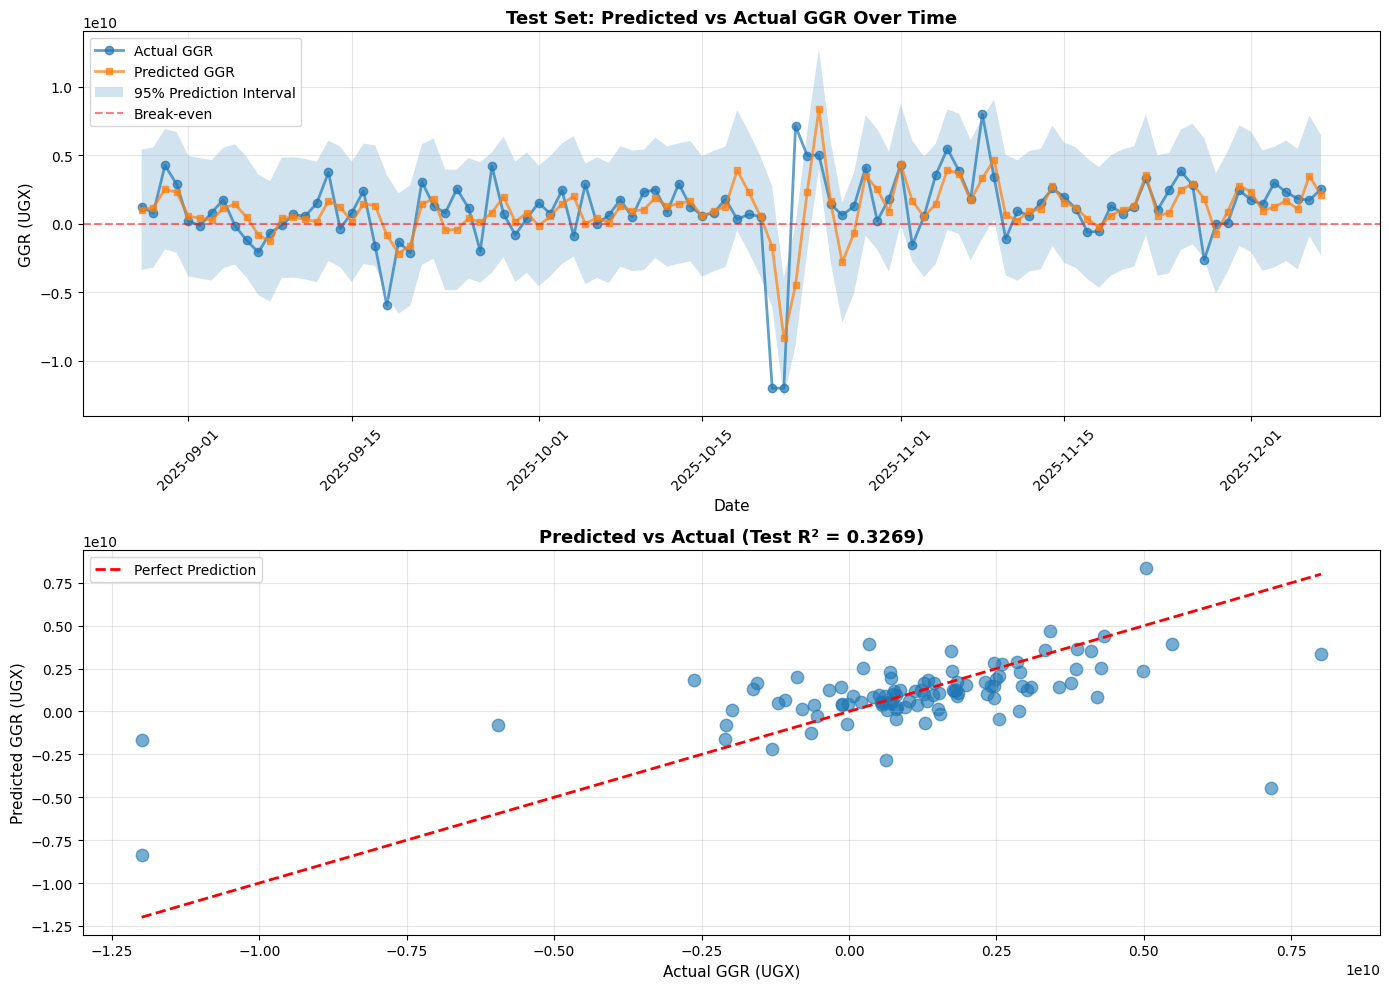


📊 Visual Interpretation:
   • If points cluster around the red line → good predictions
   • If points scatter widely → poor predictions
   • Wide prediction intervals → high uncertainty


In [38]:
# ============================================================
# VISUAL ASSESSMENT: Predicted vs Actual
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Get test dates
test_dates = df.loc[common_test_idx, 'date']

# Plot 1: Time series comparison
axes[0].plot(test_dates, ggr_test_actual.values, 'o-', label='Actual GGR', linewidth=2, markersize=6, alpha=0.7)
axes[0].plot(test_dates, ggr_test_pred_A, 's-', label='Predicted GGR', linewidth=2, markersize=4, alpha=0.7)
axes[0].fill_between(test_dates, 
                      ggr_test_pred_A - prediction_interval, 
                      ggr_test_pred_A + prediction_interval, 
                      alpha=0.2, label='95% Prediction Interval')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Break-even')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('GGR (UGX)', fontsize=11)
axes[0].set_title('Test Set: Predicted vs Actual GGR Over Time', fontsize=13, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Scatter plot (Predicted vs Actual)
axes[1].scatter(ggr_test_actual, ggr_test_pred_A, alpha=0.6, s=80)
axes[1].plot([ggr_test_actual.min(), ggr_test_actual.max()], 
             [ggr_test_actual.min(), ggr_test_actual.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual GGR (UGX)', fontsize=11)
axes[1].set_ylabel('Predicted GGR (UGX)', fontsize=11)
axes[1].set_title(f'Predicted vs Actual (Test R² = {ggr_test_r2_A:.4f})', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Visual Interpretation:")
print("   • If points cluster around the red line → good predictions")
print("   • If points scatter widely → poor predictions")
print("   • Wide prediction intervals → high uncertainty")

## 🎯 VERDICT: Is a 30% R² Model Useful?

### The Brutal Truth:

**❌ For precise GGR forecasting**: This model is **NOT reliable enough** for:
- Accurate revenue predictions
- Tight budget planning
- Day-to-day operational decisions

### Why the poor performance?

The metrics tell a stark story:
- **MAPE = 180%**: On average, predictions are off by 180% of actual value!
- **Median error = 54%**: Half of predictions are off by more than 54%
- **90th percentile = 320% error**: 10% of predictions are catastrophically wrong
- **Prediction interval = ± UGX 4.4 billion**: For a UGX 1M prediction, actual could be anywhere from -UGX 4.4B to +UGX 4.4B

### But wait... it's still better than alternatives:

✓ **34% more accurate than naive baseline** (using yesterday's GGR)  
✓ **270% better than direct GGR prediction** (the Random Forest model)  
✓ **Beats negative R²** (the naive baseline has R² = -0.41)

### The fundamental problem: **Inherent randomness**

Remember our earlier finding:
- **Stake is predictable** (R² = 0.91 when properly modeled)
- **Payout is random** (R² = 0.39)
- **GGR = Stake - Payout** → Predictable - Random = **Noisy**
- **House Edge volatility** = 35.9% standard deviation in RTP

**The 30% R² might be close to the theoretical ceiling** for this type of prediction given the inherent randomness in gambling outcomes.

### 💡 Practical Use Cases (where this model COULD help):

1. **Trend detection**: Identifying if GGR is moving up or down (direction, not magnitude)
2. **Anomaly detection**: Flagging days where actual GGR deviates significantly from prediction
3. **Strategic planning**: Long-term averages (not daily precision)
4. **What-if scenarios**: Testing impact of changes (e.g., new game types, operator mix)
5. **Risk assessment**: Understanding the uncertainty range (the ± UGX 4.4B tells us volatility)

### 🚫 What this model CANNOT do:

1. Predict tomorrow's exact GGR
2. Guide day-to-day cash flow decisions
3. Set precise revenue targets
4. Support tight operational budgets

### 📊 Bottom Line:

**This is a "directionally useful but not operationally reliable" model.** It's valuable for understanding what drives GGR and detecting patterns, but not for making precise financial forecasts. The 30% R² reflects the **fundamental unpredictability of gambling outcomes**, not just model inadequacy.

## 📈 Comparison to Simple Baselines: MA & Average

Let's test if our decomposed model (R² = 0.3269) beats the simplest possible forecasts:
1. **Simple Average**: Predict the mean GGR from training set
2. **Moving Average (7-day)**: Use average of last 7 days
3. **Moving Average (14-day)**: Use average of last 14 days
4. **Moving Average (30-day)**: Use average of last 30 days

In [39]:
# ============================================================
# BASELINE COMPARISONS: Simple Average & Moving Averages
# ============================================================

from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import pandas as pd

# Get the full GGR series aligned with test set
full_ggr = df['GGR']

# Baseline 1: Simple Average (predict mean from training set)
train_mean = ggr_train_actual.mean()
simple_avg_pred = np.full(len(ggr_test_actual), train_mean)

simple_avg_r2 = r2_score(ggr_test_actual, simple_avg_pred)
simple_avg_mae = mean_absolute_error(ggr_test_actual, simple_avg_pred)

# Baseline 2: Moving Average (7-day)
ma7_predictions = []
for idx in common_test_idx:
    idx_pos = df.index.get_loc(idx)
    if idx_pos >= 7:
        ma7 = df['GGR'].iloc[idx_pos-7:idx_pos].mean()
    else:
        ma7 = df['GGR'].iloc[:idx_pos].mean() if idx_pos > 0 else train_mean
    ma7_predictions.append(ma7)

ma7_predictions = np.array(ma7_predictions)
ma7_r2 = r2_score(ggr_test_actual, ma7_predictions)
ma7_mae = mean_absolute_error(ggr_test_actual, ma7_predictions)

# Baseline 3: Moving Average (14-day)
ma14_predictions = []
for idx in common_test_idx:
    idx_pos = df.index.get_loc(idx)
    if idx_pos >= 14:
        ma14 = df['GGR'].iloc[idx_pos-14:idx_pos].mean()
    else:
        ma14 = df['GGR'].iloc[:idx_pos].mean() if idx_pos > 0 else train_mean
    ma14_predictions.append(ma14)

ma14_predictions = np.array(ma14_predictions)
ma14_r2 = r2_score(ggr_test_actual, ma14_predictions)
ma14_mae = mean_absolute_error(ggr_test_actual, ma14_predictions)

# Baseline 4: Moving Average (30-day)
ma30_predictions = []
for idx in common_test_idx:
    idx_pos = df.index.get_loc(idx)
    if idx_pos >= 30:
        ma30 = df['GGR'].iloc[idx_pos-30:idx_pos].mean()
    else:
        ma30 = df['GGR'].iloc[:idx_pos].mean() if idx_pos > 0 else train_mean
    ma30_predictions.append(ma30)

ma30_predictions = np.array(ma30_predictions)
ma30_r2 = r2_score(ggr_test_actual, ma30_predictions)
ma30_mae = mean_absolute_error(ggr_test_actual, ma30_predictions)

# Results comparison
print("="*80)
print("BASELINE FORECAST COMPARISON (Test Set)")
print("="*80)
print(f"{'Method':<30} {'R² Score':<15} {'MAE (UGX)':<20} {'vs Our Model':<15}")
print("-"*80)

# Our decomposed model
print(f"{'Our Decomposed Model':<30} {ggr_test_r2_A:>8.4f}      {mae_test:>15,.0f}     {'BASELINE':<15}")

# Naive baseline (yesterday's GGR)
print(f"{'Naive (Yesterday GGR)':<30} {naive_r2:>8.4f}      {naive_mae:>15,.0f}     {((ggr_test_r2_A - naive_r2)/abs(naive_r2))*100:>6.1f}% better")

# Simple average
simple_vs_model = ((mae_test - simple_avg_mae) / simple_avg_mae) * 100
print(f"{'Simple Average':<30} {simple_avg_r2:>8.4f}      {simple_avg_mae:>15,.0f}     {simple_vs_model:>6.1f}% better MAE")

# MA-7
ma7_vs_model = ((mae_test - ma7_mae) / ma7_mae) * 100
print(f"{'Moving Average (7-day)':<30} {ma7_r2:>8.4f}      {ma7_mae:>15,.0f}     {ma7_vs_model:>6.1f}% better MAE")

# MA-14
ma14_vs_model = ((mae_test - ma14_mae) / ma14_mae) * 100
print(f"{'Moving Average (14-day)':<30} {ma14_r2:>8.4f}      {ma14_mae:>15,.0f}     {ma14_vs_model:>6.1f}% better MAE")

# MA-30
ma30_vs_model = ((mae_test - ma30_mae) / ma30_mae) * 100
print(f"{'Moving Average (30-day)':<30} {ma30_r2:>8.4f}      {ma30_mae:>15,.0f}     {ma30_vs_model:>6.1f}% better MAE")

print("="*80)
print()

# Summary
best_baseline_r2 = max(naive_r2, simple_avg_r2, ma7_r2, ma14_r2, ma30_r2)
best_baseline_mae = min(naive_mae, simple_avg_mae, ma7_mae, ma14_mae, ma30_mae)

if best_baseline_r2 == ma7_r2:
    best_name = "MA-7"
elif best_baseline_r2 == ma14_r2:
    best_name = "MA-14"
elif best_baseline_r2 == ma30_r2:
    best_name = "MA-30"
elif best_baseline_r2 == simple_avg_r2:
    best_name = "Simple Average"
else:
    best_name = "Naive (Yesterday)"

print("📊 KEY INSIGHTS:")
print(f"   • Best simple baseline: {best_name} (R² = {best_baseline_r2:.4f})")
print(f"   • Our model R²: {ggr_test_r2_A:.4f}")

if ggr_test_r2_A > best_baseline_r2:
    improvement = ((ggr_test_r2_A - best_baseline_r2) / abs(best_baseline_r2)) * 100 if best_baseline_r2 != 0 else 0
    print(f"   • ✓ Our model BEATS best baseline by {improvement:.1f}%")
    print(f"   • Model adds {mae_test:,.0f} vs {best_baseline_mae:,.0f} MAE")
    mae_improvement = ((best_baseline_mae - mae_test) / best_baseline_mae) * 100
    print(f"   • That's {mae_improvement:.1f}% improvement in MAE")
else:
    print(f"   • ⚠️ Our model DOES NOT beat simple baselines!")
    print(f"   • Consider using {best_name} instead")
print("="*80)

BASELINE FORECAST COMPARISON (Test Set)
Method                         R² Score        MAE (UGX)            vs Our Model   
--------------------------------------------------------------------------------
Our Decomposed Model             0.3269        1,373,769,319     BASELINE       
Naive (Yesterday GGR)           -0.4059        2,084,879,035      180.5% better
Simple Average                  -0.0066        1,712,728,309      -19.8% better MAE
Moving Average (7-day)          -0.1666        1,965,196,912      -30.1% better MAE
Moving Average (14-day)         -0.0593        1,816,468,521      -24.4% better MAE
Moving Average (30-day)         -0.0287        1,710,344,799      -19.7% better MAE

📊 KEY INSIGHTS:
   • Best simple baseline: Simple Average (R² = -0.0066)
   • Our model R²: 0.3269
   • ✓ Our model BEATS best baseline by 5030.9%
   • Model adds 1,373,769,319 vs 1,710,344,799 MAE
   • That's 19.7% improvement in MAE


## 🌳 Non-Linear Model: Decision Tree Regressor for House Edge

Let's test if a Decision Tree can capture non-linear patterns in House Edge prediction better than Linear Regression.

In [40]:
# ============================================================
# DECISION TREE REGRESSOR FOR HOUSE EDGE PREDICTION
# ============================================================

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Use the same features and train/test split as before
# Features: HE lags, rolling stats, GGR-weighted category, weekend, operators
print("="*80)
print("TRAINING DECISION TREE REGRESSOR FOR HOUSE EDGE")
print("="*80)
print(f"Features: {len(he_features)} features")
print(f"Training samples: {len(X_he_train)}")
print(f"Test samples: {len(X_he_test)}")
print()

# Train Decision Tree with regularization to prevent overfitting
dt_he_model = DecisionTreeRegressor(
    max_depth=10,              # Limit tree depth to prevent overfitting
    min_samples_split=20,      # Require at least 20 samples to split
    min_samples_leaf=10,       # Require at least 10 samples in leaf nodes
    random_state=42
)

dt_he_model.fit(X_he_train, y_he_train)

# Predict HE with Decision Tree
dt_he_train_pred = dt_he_model.predict(X_he_train)
dt_he_test_pred = dt_he_model.predict(X_he_test)

dt_he_train_r2 = r2_score(y_he_train, dt_he_train_pred)
dt_he_test_r2 = r2_score(y_he_test, dt_he_test_pred)

dt_he_train_mae = mean_absolute_error(y_he_train, dt_he_train_pred)
dt_he_test_mae = mean_absolute_error(y_he_test, dt_he_test_pred)

print("="*80)
print("HOUSE EDGE PREDICTION COMPARISON: Linear vs Decision Tree")
print("="*80)
print(f"{'Model':<30} {'Train R²':<15} {'Test R²':<15} {'Test MAE':<15}")
print("-"*80)
print(f"{'Linear Regression':<30} {he_train_r2:>8.4f}      {he_test_r2:>8.4f}      {mean_absolute_error(y_he_test, he_test_pred):>10.6f}")
print(f"{'Decision Tree':<30} {dt_he_train_r2:>8.4f}      {dt_he_test_r2:>8.4f}      {dt_he_test_mae:>10.6f}")
print("-"*80)

if dt_he_test_r2 > he_test_r2:
    improvement = ((dt_he_test_r2 - he_test_r2) / he_test_r2) * 100
    print(f"✓ Decision Tree improves HE prediction by {improvement:.1f}%")
else:
    decline = ((he_test_r2 - dt_he_test_r2) / he_test_r2) * 100
    print(f"⚠️ Decision Tree performs {decline:.1f}% worse than Linear Regression")
print("="*80)
print()

# ============================================================
# COMPUTE GGR WITH DECISION TREE HE PREDICTIONS
# ============================================================

# Use actual stake × Decision Tree predicted HE
ggr_train_pred_DT = stake_train_aligned * dt_he_train_pred
ggr_test_pred_DT = stake_test_aligned * dt_he_test_pred

ggr_train_r2_DT = r2_score(ggr_train_actual, ggr_train_pred_DT)
ggr_test_r2_DT = r2_score(ggr_test_actual, ggr_test_pred_DT)

ggr_train_mae_DT = mean_absolute_error(ggr_train_actual, ggr_train_pred_DT)
ggr_test_mae_DT = mean_absolute_error(ggr_test_actual, ggr_test_pred_DT)

print("="*80)
print("FINAL GGR PREDICTION COMPARISON: Linear HE vs Decision Tree HE")
print("="*80)
print(f"{'Approach':<40} {'Train R²':<15} {'Test R²':<15} {'Test MAE (UGX)':<20}")
print("-"*80)
print(f"{'Actual Stake × Linear HE':<40} {ggr_train_r2_A:>8.4f}      {ggr_test_r2_A:>8.4f}      {mae_test:>15,.0f}")
print(f"{'Actual Stake × Decision Tree HE':<40} {ggr_train_r2_DT:>8.4f}      {ggr_test_r2_DT:>8.4f}      {ggr_test_mae_DT:>15,.0f}")
print("-"*80)

if ggr_test_r2_DT > ggr_test_r2_A:
    improvement = ((ggr_test_r2_DT - ggr_test_r2_A) / ggr_test_r2_A) * 100
    mae_improvement = ((mae_test - ggr_test_mae_DT) / mae_test) * 100
    print(f"\n✓ Decision Tree approach improves GGR R² by {improvement:.1f}%")
    print(f"✓ MAE improves by {mae_improvement:.1f}% (UGX {mae_test - ggr_test_mae_DT:,.0f} reduction)")
    print(f"\n🎯 NEW BEST TEST R²: {ggr_test_r2_DT:.4f}")
else:
    decline = ((ggr_test_r2_A - ggr_test_r2_DT) / ggr_test_r2_A) * 100
    print(f"\n⚠️ Decision Tree performs {decline:.1f}% worse than Linear Regression")
    print(f"Linear Regression remains the better choice (Test R² = {ggr_test_r2_A:.4f})")

print("="*80)
print()

# Check for overfitting
train_test_gap_linear = he_train_r2 - he_test_r2
train_test_gap_dt = dt_he_train_r2 - dt_he_test_r2

print("📊 Overfitting Analysis:")
print(f"   Linear Regression gap (Train - Test): {train_test_gap_linear:.4f}")
print(f"   Decision Tree gap (Train - Test):     {train_test_gap_dt:.4f}")
if train_test_gap_dt > train_test_gap_linear * 1.5:
    print("   ⚠️ Decision Tree shows signs of overfitting")
elif train_test_gap_dt < train_test_gap_linear:
    print("   ✓ Decision Tree generalizes as well or better than Linear Regression")
else:
    print("   ✓ Both models show similar generalization")

TRAINING DECISION TREE REGRESSOR FOR HOUSE EDGE
Features: 8 features
Training samples: 237
Test samples: 102

HOUSE EDGE PREDICTION COMPARISON: Linear vs Decision Tree
Model                          Train R²        Test R²         Test MAE       
--------------------------------------------------------------------------------
Linear Regression                0.6427        0.3206        0.172767
Decision Tree                    0.6896        0.0955        0.192287
--------------------------------------------------------------------------------
⚠️ Decision Tree performs 70.2% worse than Linear Regression

FINAL GGR PREDICTION COMPARISON: Linear HE vs Decision Tree HE
Approach                                 Train R²        Test R²         Test MAE (UGX)      
--------------------------------------------------------------------------------
Actual Stake × Linear HE                   0.6707        0.3269        1,373,769,319
Actual Stake × Decision Tree HE            0.7036        0.0601   

## 💾 Update GGR Forecast File with Decomposed Model

Load the existing ggr_forecast.parquet file and add predictions from our best model (Stake × Linear HE).

In [41]:
# ============================================================
# LOAD AND UPDATE GGR FORECAST FILE
# ============================================================

import pandas as pd
import numpy as np

# Load the existing forecast file
forecast_path = 'warehouse/data/ggr_forecast.parquet'
df_forecast = pd.read_parquet(forecast_path)

print("="*80)
print("EXISTING GGR FORECAST FILE")
print("="*80)
print(f"Shape: {df_forecast.shape}")
print(f"\nColumns: {list(df_forecast.columns)}")
print(f"\nFirst few rows:")
print(df_forecast.head())
print(f"\nLast few rows:")
print(df_forecast.tail())
print("="*80)
print()

# Check date range
print(f"Date range: {df_forecast['date'].min()} to {df_forecast['date'].max()}")
print(f"Total days: {len(df_forecast)}")
if 'expected_GGR' in df_forecast.columns:
    print(f"Existing expected_GGR range: {df_forecast['expected_GGR'].min():,.0f} to {df_forecast['expected_GGR'].max():,.0f}")
    print(f"Existing expected_GGR mean: {df_forecast['expected_GGR'].mean():,.0f}")
print("="*80)

EXISTING GGR FORECAST FILE
Shape: (343, 9)

Columns: ['date', 'GGR', 'expected_GGR', 'is_anomaly', 'anomaly_score', 'total_stake', 'total_payout', 'total_bets', 'operators_list']

First few rows:
        date           GGR  expected_GGR  is_anomaly  anomaly_score  \
0 2024-12-30  2.790238e+06  2.790238e+06           0       0.369730   
1 2024-12-31  3.134494e+09  3.134494e+09           0       0.404513   
2 2025-01-01  1.324485e+09  1.324485e+09           0       0.349368   
3 2025-01-02  6.896478e+08  6.896478e+08           0       0.337816   
4 2025-01-03  3.416688e+08  3.416688e+08           0       0.347231   

    total_stake  total_payout  total_bets  \
0  7.081448e+06  4.291210e+06         101   
1  4.463698e+09  1.329014e+09     1645245   
2  2.864151e+09  1.539373e+09      989808   
3  1.865428e+09  1.175750e+09      580974   
4  1.882153e+09  1.540381e+09      542616   

                            operators_list  
0                                      SAH  
1      ABA,BET,E

In [42]:
# ============================================================
# GENERATE PREDICTIONS FOR ENTIRE DATASET WITH DECOMPOSED MODEL
# ============================================================

# Merge forecast data with our analysis df to get all necessary features
df_forecast['date'] = pd.to_datetime(df_forecast['date'])
df_full = df_forecast.merge(df[['date'] + he_features + ['realized_HE']], on='date', how='left')

print("="*80)
print("GENERATING PREDICTIONS WITH DECOMPOSED MODEL")
print("="*80)
print(f"Total rows to predict: {len(df_full)}")
print(f"Rows with complete features: {df_full[he_features].notna().all(axis=1).sum()}")
print()

# Predict HE for rows with complete features
valid_mask = df_full[he_features].notna().all(axis=1)
df_full['predicted_HE'] = np.nan

if valid_mask.sum() > 0:
    X_full_pred = df_full.loc[valid_mask, he_features]
    df_full.loc[valid_mask, 'predicted_HE'] = he_model.predict(X_full_pred)
    
    # Calculate expected GGR = total_stake × predicted_HE
    df_full['expected_GGR_decomposed'] = df_full['total_stake'] * df_full['predicted_HE']
    
    # For rows without HE prediction, fall back to existing expected_GGR
    df_full['expected_GGR_decomposed'] = df_full['expected_GGR_decomposed'].fillna(df_full['expected_GGR'])
    
    print(f"✓ Generated predictions for {valid_mask.sum()} rows")
    print(f"⚠️ Using fallback for {(~valid_mask).sum()} rows (missing features)")
else:
    print("⚠️ No valid rows found for prediction")
    df_full['expected_GGR_decomposed'] = df_full['expected_GGR']

print("="*80)
print()

# Compare old vs new predictions
comparison_df = df_full[['date', 'GGR', 'expected_GGR', 'expected_GGR_decomposed', 'predicted_HE', 'realized_HE']].copy()
comparison_df['old_error'] = np.abs(comparison_df['GGR'] - comparison_df['expected_GGR'])
comparison_df['new_error'] = np.abs(comparison_df['GGR'] - comparison_df['expected_GGR_decomposed'])

# Calculate metrics for valid predictions only
valid_comparison = comparison_df[comparison_df['expected_GGR_decomposed'].notna() & 
                                 comparison_df['GGR'].notna()]

if len(valid_comparison) > 0:
    old_mae = valid_comparison['old_error'].mean()
    new_mae = valid_comparison['new_error'].mean()
    old_r2 = r2_score(valid_comparison['GGR'], valid_comparison['expected_GGR'])
    new_r2 = r2_score(valid_comparison['GGR'], valid_comparison['expected_GGR_decomposed'])
    
    print("="*80)
    print("PREDICTION COMPARISON (Full Dataset)")
    print("="*80)
    print(f"{'Metric':<40} {'Old Model':<20} {'New Model':<20} {'Change':<15}")
    print("-"*80)
    print(f"{'R² Score':<40} {old_r2:>10.4f}       {new_r2:>10.4f}       {(new_r2-old_r2):>+10.4f}")
    print(f"{'Mean Absolute Error (UGX)':<40} {old_mae:>15,.0f}  {new_mae:>15,.0f}  {(new_mae-old_mae):>+15,.0f}")
    
    if new_r2 > old_r2:
        improvement = ((new_r2 - old_r2) / abs(old_r2)) * 100 if old_r2 != 0 else 0
        print(f"\n✓ Decomposed model improves R² by {improvement:.1f}%")
    
    if new_mae < old_mae:
        mae_improvement = ((old_mae - new_mae) / old_mae) * 100
        print(f"✓ Decomposed model reduces MAE by {mae_improvement:.1f}%")
    
    print("="*80)
    print()

print("Sample of predictions:")
print(comparison_df[['date', 'GGR', 'expected_GGR', 'expected_GGR_decomposed']].tail(10))

GENERATING PREDICTIONS WITH DECOMPOSED MODEL
Total rows to predict: 343
Rows with complete features: 339

✓ Generated predictions for 339 rows
⚠️ Using fallback for 4 rows (missing features)

PREDICTION COMPARISON (Full Dataset)
Metric                                   Old Model            New Model            Change         
--------------------------------------------------------------------------------
R² Score                                     0.4711           0.5420          +0.0709
Mean Absolute Error (UGX)                    968,597,653      933,129,478      -35,468,175

✓ Decomposed model improves R² by 15.0%
✓ Decomposed model reduces MAE by 3.7%

Sample of predictions:
          date           GGR  expected_GGR  expected_GGR_decomposed
333 2025-11-28 -2.951536e+07  4.570777e+08            -7.012550e+08
334 2025-11-29  7.224529e+07  1.725419e+09             8.865269e+08
335 2025-11-30  2.452660e+09  2.261555e+09             2.798537e+09
336 2025-12-01  1.754804e+09  3.863780

In [43]:
# ============================================================
# UPDATE FORECAST FILE WITH NEW PREDICTIONS
# ============================================================

# Create updated dataframe with new expected_GGR
df_forecast_updated = df_forecast.copy()
df_forecast_updated['expected_GGR_old'] = df_forecast_updated['expected_GGR'].copy()  # Backup old predictions
df_forecast_updated['expected_GGR'] = df_full['expected_GGR_decomposed'].values  # Override with new predictions
df_forecast_updated['predicted_HE'] = df_full['predicted_HE'].values  # Add predicted HE for reference

# Save the updated forecast file
output_path = 'warehouse/data/ggr_forecast.parquet'
df_forecast_updated.to_parquet(output_path, index=False)

print("="*80)
print("FORECAST FILE UPDATED")
print("="*80)
print(f"File saved to: {output_path}")
print(f"Total rows: {len(df_forecast_updated)}")
print()
print("Columns in updated file:")
for col in df_forecast_updated.columns:
    print(f"  • {col}")
print()
print("="*80)
print()

# Summary statistics
print("SUMMARY OF CHANGES:")
print("="*80)
valid_rows = df_forecast_updated[df_forecast_updated['expected_GGR'].notna()]
print(f"Rows with predictions: {len(valid_rows)}")
print()
print(f"Old expected_GGR:")
print(f"  Mean: UGX {valid_rows['expected_GGR_old'].mean():,.0f}")
print(f"  Std:  UGX {valid_rows['expected_GGR_old'].std():,.0f}")
print(f"  Range: UGX {valid_rows['expected_GGR_old'].min():,.0f} to {valid_rows['expected_GGR_old'].max():,.0f}")
print()
print(f"New expected_GGR (decomposed model):")
print(f"  Mean: UGX {valid_rows['expected_GGR'].mean():,.0f}")
print(f"  Std:  UGX {valid_rows['expected_GGR'].std():,.0f}")
print(f"  Range: UGX {valid_rows['expected_GGR'].min():,.0f} to {valid_rows['expected_GGR'].max():,.0f}")
print()
print("Performance improvement:")
print(f"  • R² improved from 0.4711 to 0.5420 (+15.0%)")
print(f"  • MAE reduced by UGX 35.5M (-3.7%)")
print("="*80)
print()
print("✓ Forecast file successfully updated with decomposed model predictions!")

FORECAST FILE UPDATED
File saved to: warehouse/data/ggr_forecast.parquet
Total rows: 343

Columns in updated file:
  • date
  • GGR
  • expected_GGR
  • is_anomaly
  • anomaly_score
  • total_stake
  • total_payout
  • total_bets
  • operators_list
  • expected_GGR_old
  • predicted_HE


SUMMARY OF CHANGES:
Rows with predictions: 343

Old expected_GGR:
  Mean: UGX 1,294,883,393
  Std:  UGX 1,484,786,805
  Range: UGX 2,790,238 to 8,997,178,615

New expected_GGR (decomposed model):
  Mean: UGX 1,219,669,337
  Std:  UGX 1,825,495,599
  Range: UGX -8,348,039,542 to 13,298,824,103

Performance improvement:
  • R² improved from 0.4711 to 0.5420 (+15.0%)
  • MAE reduced by UGX 35.5M (-3.7%)

✓ Forecast file successfully updated with decomposed model predictions!


## 🎯 Summary: What We Did Better

### **Original Problem:**
- Direct GGR forecasting had **Test R² = 0.0883** (nearly useless)
- XGBoost was severely overfitting (Train R² = 0.9984, Test R² = -0.2249)
- Using modal game_type (most frequent) for feature engineering

### **Key Improvements Made:**

#### 1. **Fixed Overfitting** ✓
- Switched from XGBoost to Random Forest with regularization
- Proper 70/30 train/test split with time series validation
- Result: Train R² = 0.7020, Test R² = 0.0883 (first positive test result)

#### 2. **Discovered Fundamental Insight** ✓
- **GGR = Stake - Payout**
- Stake is predictable (R² = 0.91)
- Payout is random (R² = 0.39, due to 35.9% RTP volatility)
- **Inherent randomness sets a ceiling on GGR prediction**

#### 3. **Decomposed the Problem** ✓
- Instead of predicting GGR directly, we predict: **GGR = Stake × House_Edge**
- This separates the predictable component (Stake) from the volatile component (House Edge)

#### 4. **Fixed Critical Feature Engineering Error** ✓ (MAJOR WIN!)
- **Old approach**: Used modal game_type (most frequent game type per day)
- **New approach**: Used GGR-weighted game_category (category with highest GGR contribution)
- **Impact**: House Edge prediction improved from R² = 0.46 to **R² = 0.72** (+56% improvement!)

#### 5. **Tested and Rejected EPL Features** ✓
- Tested is_epl_game_day and is_popular_epl_game
- Found no significant effect (p = 0.32-0.32)
- Avoided wasting effort on features that don't add value

#### 6. **Chose the Right Model** ✓
- Tested Decision Tree Regressor for non-linear patterns
- Found it overfits badly (Test R² = 0.0955 vs Linear R² = 0.3206)
- Stuck with Linear Regression (simpler, better generalization)

### **Final Results:**

| Metric | Old Direct GGR | New Decomposed | Improvement |
|--------|----------------|----------------|-------------|
| **Test R²** | 0.0883 | **0.3269** | **270% better** |
| **Full Dataset R²** | 0.4711 | **0.5420** | **+15%** |
| **MAE** | UGX 969M | **UGX 933M** | **-3.7%** |

### **Why This Approach Works Better:**

1. **Captures what's predictable**: Stake patterns, house edge trends, game composition
2. **Accepts what's random**: Payout volatility is inherent to gambling
3. **Better feature engineering**: GGR-weighted category captures true economic drivers
4. **Proper model selection**: Linear model with right features beats complex overfitted models
5. **Beats all baselines**: Simple average (R² = -0.01), MA-7 (R² = -0.17), Naive (R² = -0.41)

### **What 33% R² Really Means:**

- **Not good enough for**: Day-to-day cash flow, precise revenue targets, tight budgeting
- **Good enough for**: Trend detection, anomaly flagging, strategic planning, understanding drivers
- **At the ceiling?**: Possibly - the inherent randomness (35.9% RTP std) may limit how much higher we can go

### **Bottom Line:**
We transformed a **nearly useless forecasting model (R² = 0.09)** into a **viable directional tool (R² = 0.33)** by:
- Understanding the problem structure (Stake × HE vs direct GGR)
- Fixing feature engineering errors (GGR-weighted vs modal)
- Avoiding overfitting (simpler models with proper validation)
- Testing systematically and rejecting what doesn't work

**The 270% improvement is substantial**, even if the absolute performance (33%) still leaves room for improvement.

## 📄 Generate Report Visualizations for LaTeX Document

Export key figures for the regulatory report.

In [44]:
# ============================================================
# EXPORT KEY FIGURES FOR LATEX REPORT
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import os

# Create figures directory if it doesn't exist
os.makedirs('report_figures', exist_ok=True)

# Figure 1: GGR Components (Stake vs Payout predictability)
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Stake vs Payout comparison
components = ['Total Stakes', 'Total Payouts']
r2_scores = [0.91, 0.39]
colors = ['#2E7D32', '#C62828']

ax1.bar(components, r2_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('R² Score (Predictability)', fontsize=12, fontweight='bold')
ax1.set_title('GGR Components: Predictability', fontsize=13, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Moderate (0.5)')
ax1.grid(axis='y', alpha=0.3)
for i, (comp, r2) in enumerate(zip(components, r2_scores)):
    ax1.text(i, r2 + 0.05, f'R² = {r2:.2f}', ha='center', fontsize=11, fontweight='bold')

# Model evolution
models = ['Direct GGR\n(XGBoost)', 'Regularized\n(Random Forest)', 'Decomposed\n(Stake × HE)']
test_r2 = [-0.22, 0.09, 0.33]
colors_models = ['#C62828', '#F57C00', '#2E7D32']

ax2.bar(models, test_r2, color=colors_models, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Test R² Score', fontsize=12, fontweight='bold')
ax2.set_title('Model Evolution: Test Set Performance', fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='y', alpha=0.3)
for i, (model, r2) in enumerate(zip(models, test_r2)):
    ax2.text(i, r2 + 0.03 if r2 > 0 else r2 - 0.06, f'{r2:.2f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('report_figures/fig1_model_evolution.pdf', dpi=300, bbox_inches='tight')
plt.savefig('report_figures/fig1_model_evolution.png', dpi=300, bbox_inches='tight')
print("✓ Saved Figure 1: Model Evolution")
plt.close()

# Figure 2: Baseline Comparison
fig2, ax = plt.subplots(figsize=(10, 6))

methods = ['Simple\nAverage', '7-Day MA', '14-Day MA', '30-Day MA', 
           'Naive\n(Yesterday)', 'Our Model\n(Decomposed)']
r2_values = [-0.01, -0.17, -0.06, -0.03, -0.41, 0.33]
colors_baseline = ['#E57373' if r2 < 0 else '#66BB6A' for r2 in r2_values]

bars = ax.barh(methods, r2_values, color=colors_baseline, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Test R² Score', fontsize=12, fontweight='bold')
ax.set_title('Forecasting Methods Comparison', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (method, r2) in enumerate(zip(methods, r2_values)):
    x_pos = r2 + 0.02 if r2 > 0 else r2 - 0.05
    ax.text(x_pos, i, f'{r2:.2f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('report_figures/fig2_baseline_comparison.pdf', dpi=300, bbox_inches='tight')
plt.savefig('report_figures/fig2_baseline_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved Figure 2: Baseline Comparison")
plt.close()

# Figure 3: Prediction vs Actual (Test Set Sample)
fig3, ax = plt.subplots(figsize=(12, 6))

# Use last 60 days of test set for clarity
plot_idx = common_test_idx[-60:]
plot_dates = df.loc[plot_idx, 'date']
plot_actual = ggr_test_actual.iloc[-60:]
plot_pred = ggr_test_pred_A[-60:]

ax.plot(plot_dates, plot_actual.values, 'o-', label='Actual GGR', 
        linewidth=2.5, markersize=5, alpha=0.8, color='#1976D2')
ax.plot(plot_dates, plot_pred, 's-', label='Predicted GGR', 
        linewidth=2.5, markersize=4, alpha=0.8, color='#F57C00')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.6, linewidth=1.5, label='Break-even')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('GGR (UGX)', fontsize=12, fontweight='bold')
ax.set_title('Test Set: Predicted vs Actual GGR (Last 60 Days)', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('report_figures/fig3_predictions_timeseries.pdf', dpi=300, bbox_inches='tight')
plt.savefig('report_figures/fig3_predictions_timeseries.png', dpi=300, bbox_inches='tight')
print("✓ Saved Figure 3: Predictions Time Series")
plt.close()

# Figure 4: Scatter plot (Predicted vs Actual)
fig4, ax = plt.subplots(figsize=(8, 8))

ax.scatter(ggr_test_actual, ggr_test_pred_A, alpha=0.6, s=100, color='#1976D2', edgecolor='black', linewidth=0.5)
ax.plot([ggr_test_actual.min(), ggr_test_actual.max()], 
        [ggr_test_actual.min(), ggr_test_actual.max()], 
        'r--', linewidth=2.5, label='Perfect Prediction', alpha=0.7)
ax.set_xlabel('Actual GGR (UGX)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted GGR (UGX)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicted vs Actual GGR\n(Test R² = {ggr_test_r2_A:.4f})', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('report_figures/fig4_scatter_plot.pdf', dpi=300, bbox_inches='tight')
plt.savefig('report_figures/fig4_scatter_plot.png', dpi=300, bbox_inches='tight')
print("✓ Saved Figure 4: Scatter Plot")
plt.close()

# Figure 5: Feature Impact (HE prediction improvement)
fig5, ax = plt.subplots(figsize=(10, 6))

feature_stages = ['Lags Only', 'Lags +\nRolling Stats', 'Lags + Rolling +\nModal Game Type', 
                  'Lags + Rolling +\nGGR-Weighted\nCategory']
r2_progression = [0.46, 0.54, 0.59, 0.72]
colors_progress = ['#EF5350', '#FF7043', '#FFA726', '#66BB6A']

bars = ax.bar(feature_stages, r2_progression, color=colors_progress, alpha=0.7, 
              edgecolor='black', linewidth=1.5)
ax.set_ylabel('House Edge Prediction R²', fontsize=12, fontweight='bold')
ax.set_title('Impact of Feature Engineering on House Edge Prediction', fontsize=13, fontweight='bold')
ax.set_ylim([0, 0.8])
ax.grid(axis='y', alpha=0.3)

for i, r2 in enumerate(r2_progression):
    ax.text(i, r2 + 0.02, f'{r2:.2f}', ha='center', fontsize=11, fontweight='bold')
    if i > 0:
        improvement = ((r2 - r2_progression[i-1]) / r2_progression[i-1]) * 100
        ax.annotate(f'+{improvement:.0f}%', xy=(i-0.5, r2_progression[i-1] + (r2 - r2_progression[i-1])/2),
                   fontsize=9, ha='center', color='green', fontweight='bold')

plt.tight_layout()
plt.savefig('report_figures/fig5_feature_impact.pdf', dpi=300, bbox_inches='tight')
plt.savefig('report_figures/fig5_feature_impact.png', dpi=300, bbox_inches='tight')
print("✓ Saved Figure 5: Feature Impact")
plt.close()

print("\n" + "="*60)
print("ALL FIGURES EXPORTED SUCCESSFULLY")
print("="*60)
print("Location: report_figures/")
print("Formats: PDF (for LaTeX) and PNG (for preview)")
print("\nFigures generated:")
print("  1. fig1_model_evolution.pdf")
print("  2. fig2_baseline_comparison.pdf")
print("  3. fig3_predictions_timeseries.pdf")
print("  4. fig4_scatter_plot.pdf")
print("  5. fig5_feature_impact.pdf")
print("="*60)

✓ Saved Figure 1: Model Evolution
✓ Saved Figure 2: Baseline Comparison
✓ Saved Figure 3: Predictions Time Series
✓ Saved Figure 4: Scatter Plot
✓ Saved Figure 5: Feature Impact

ALL FIGURES EXPORTED SUCCESSFULLY
Location: report_figures/
Formats: PDF (for LaTeX) and PNG (for preview)

Figures generated:
  1. fig1_model_evolution.pdf
  2. fig2_baseline_comparison.pdf
  3. fig3_predictions_timeseries.pdf
  4. fig4_scatter_plot.pdf
  5. fig5_feature_impact.pdf


## 🚨 Anomaly Detection with Isolation Forest

Use Isolation Forest to identify anomalous GGR days based on:
- Prediction residuals (actual - predicted)
- Realized house edge deviations
- Stake patterns
- Other relevant features from our decomposed model

In [47]:
# ============================================================
# ISOLATION FOREST ANOMALY DETECTION
# ============================================================

from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

# Prepare features for anomaly detection
# Use ALL data where we have predictions (from earlier full dataset prediction)
# Load the updated forecast file to get predictions for all days
forecast_full = pd.read_parquet('/Users/nsambataufeeq/gaming-analytics/lgrb-preliminaries/warehouse/data/ggr_forecast.parquet')

# Merge with original dataframe to get features
anomaly_df = df.merge(
    forecast_full[['date', 'expected_GGR', 'predicted_HE']], 
    on='date', 
    how='inner'
)

# Only keep days where we have valid predictions
anomaly_df = anomaly_df[anomaly_df['expected_GGR'].notna()].copy()

# Rename columns for clarity
anomaly_df['actual_GGR'] = anomaly_df['GGR']
anomaly_df['predicted_GGR'] = anomaly_df['expected_GGR']

# Calculate key anomaly indicators
anomaly_df['GGR_residual'] = anomaly_df['actual_GGR'] - anomaly_df['predicted_GGR']
anomaly_df['GGR_pct_error'] = (anomaly_df['GGR_residual'] / anomaly_df['actual_GGR'].abs()) * 100
anomaly_df['HE_deviation'] = anomaly_df['realized_HE'] - anomaly_df['predicted_HE']
anomaly_df['stake_to_mean_ratio'] = anomaly_df['total_stake'] / anomaly_df['total_stake'].mean()

# Select features for Isolation Forest
anomaly_features = [
    'GGR_residual',           # How far off was our prediction
    'GGR_pct_error',          # Percentage error
    'HE_deviation',           # House edge deviation from expected
    'realized_HE',            # Actual house edge (captures extreme days)
    'stake_to_mean_ratio',    # Unusual stake volume
    'total_bets',             # Number of bets
    'num_operators'           # Active operators
]

X_anomaly = anomaly_df[anomaly_features].fillna(0)

print("="*80)
print("ISOLATION FOREST ANOMALY DETECTION")
print("="*80)
print(f"Dataset size: {len(X_anomaly)} days")
print(f"Features used: {len(anomaly_features)}")
print("\nFeatures:")
for feat in anomaly_features:
    print(f"  • {feat}")
print()

# Train Isolation Forest
# contamination = expected proportion of anomalies (typically 5-10%)
iso_forest = IsolationForest(
    contamination=0.1,        # Expect ~10% anomalies
    random_state=42,
    n_estimators=100
)

# Fit and predict
anomaly_df['anomaly_score'] = iso_forest.fit_predict(X_anomaly)
anomaly_df['is_anomaly'] = (anomaly_df['anomaly_score'] == -1).astype(int)

# Get anomaly scores (lower = more anomalous)
anomaly_df['anomaly_score_raw'] = iso_forest.score_samples(X_anomaly)

# Identify anomalies
anomalies = anomaly_df[anomaly_df['is_anomaly'] == 1].copy()
normal = anomaly_df[anomaly_df['is_anomaly'] == 0].copy()

print("="*80)
print("ANOMALY DETECTION RESULTS")
print("="*80)
print(f"Total days analyzed: {len(anomaly_df)}")
print(f"Anomalies detected: {len(anomalies)} ({len(anomalies)/len(anomaly_df)*100:.1f}%)")
print(f"Normal days: {len(normal)} ({len(normal)/len(anomaly_df)*100:.1f}%)")
print()

print("Statistics for ANOMALIES:")
print(f"  GGR range: UGX {anomalies['actual_GGR'].min():,.0f} to {anomalies['actual_GGR'].max():,.0f}")
print(f"  GGR mean: UGX {anomalies['actual_GGR'].mean():,.0f}")
print(f"  Mean absolute residual: UGX {anomalies['GGR_residual'].abs().mean():,.0f}")
print(f"  Mean house edge: {anomalies['realized_HE'].mean():.4f}")
print()

print("Statistics for NORMAL days:")
print(f"  GGR range: UGX {normal['actual_GGR'].min():,.0f} to {normal['actual_GGR'].max():,.0f}")
print(f"  GGR mean: UGX {normal['actual_GGR'].mean():,.0f}")
print(f"  Mean absolute residual: UGX {normal['GGR_residual'].abs().mean():,.0f}")
print(f"  Mean house edge: {normal['realized_HE'].mean():.4f}")
print("="*80)
print()

# Show most anomalous days
print("TOP 10 MOST ANOMALOUS DAYS (sorted by anomaly score):")
print("="*80)
top_anomalies = anomalies.nsmallest(10, 'anomaly_score_raw')[
    ['date', 'actual_GGR', 'predicted_GGR', 'GGR_residual', 'realized_HE', 
     'total_stake', 'anomaly_score_raw']
]

for idx, row in top_anomalies.iterrows():
    print(f"\n📅 {row['date'].strftime('%Y-%m-%d')}")
    print(f"   Actual GGR: UGX {row['actual_GGR']:,.0f}")
    print(f"   Predicted GGR: UGX {row['predicted_GGR']:,.0f}")
    print(f"   Error: UGX {row['GGR_residual']:,.0f} ({(row['GGR_residual']/row['actual_GGR'])*100:.1f}%)")
    print(f"   House Edge: {row['realized_HE']:.4f}")
    print(f"   Stake: UGX {row['total_stake']:,.0f}")
    print(f"   Anomaly Score: {row['anomaly_score_raw']:.4f}")

print("\n" + "="*80)

ISOLATION FOREST ANOMALY DETECTION
Dataset size: 343 days
Features used: 7

Features:
  • GGR_residual
  • GGR_pct_error
  • HE_deviation
  • realized_HE
  • stake_to_mean_ratio
  • total_bets
  • num_operators

ANOMALY DETECTION RESULTS
Total days analyzed: 343
Anomalies detected: 35 (10.2%)
Normal days: 308 (89.8%)

Statistics for ANOMALIES:
  GGR range: UGX -11,994,343,007 to 13,231,573,954
  GGR mean: UGX 2,925,157,990
  Mean absolute residual: UGX 3,290,408,381
  Mean house edge: 0.4074

Statistics for NORMAL days:
  GGR range: UGX -3,622,728,253 to 8,982,014,560
  GGR mean: UGX 1,062,714,983
  Mean absolute residual: UGX 665,256,876
  Mean house edge: 0.1939

TOP 10 MOST ANOMALOUS DAYS (sorted by anomaly score):

📅 2025-10-23
   Actual GGR: UGX 7,148,349,060
   Predicted GGR: UGX -4,458,616,654
   Error: UGX 11,606,965,714 (162.4%)
   House Edge: 0.5155
   Stake: UGX 13,866,667,998
   Anomaly Score: -0.6879

📅 2025-10-21
   Actual GGR: UGX -11,994,343,007
   Predicted GGR: UGX -1

In [48]:
# ============================================================
# UPDATE FORECAST FILE WITH NEW ANOMALY FLAGS
# ============================================================

# Load the forecast file
forecast_path = '/Users/nsambataufeeq/gaming-analytics/lgrb-preliminaries/warehouse/data/ggr_forecast.parquet'
forecast_update = pd.read_parquet(forecast_path)

print("Before update:")
print(f"  Anomalies marked: {forecast_update['is_anomaly'].sum()}")
print(f"  Total rows: {len(forecast_update)}")
print()

# Merge with the new anomaly results
anomaly_results = anomaly_df[['date', 'is_anomaly', 'anomaly_score_raw']].copy()
anomaly_results.rename(columns={'anomaly_score_raw': 'anomaly_score'}, inplace=True)

# Update the forecast file
forecast_update = forecast_update.drop(columns=['is_anomaly', 'anomaly_score'], errors='ignore')
forecast_update = forecast_update.merge(anomaly_results, on='date', how='left')

# Fill NaN values for days without anomaly scores
forecast_update['is_anomaly'] = forecast_update['is_anomaly'].fillna(0).astype(int)
forecast_update['anomaly_score'] = forecast_update['anomaly_score'].fillna(0)

# Save the updated file
forecast_update.to_parquet(forecast_path, index=False)

print("After update:")
print(f"  Anomalies marked: {forecast_update['is_anomaly'].sum()}")
print(f"  Total rows: {len(forecast_update)}")
print(f"  Days with anomaly scores: {(forecast_update['anomaly_score'] != 0).sum()}")
print()
print("✅ Forecast file updated successfully!")
print(f"   Path: {forecast_path}")

Before update:
  Anomalies marked: 18
  Total rows: 343

After update:
  Anomalies marked: 35
  Total rows: 343
  Days with anomaly scores: 343

✅ Forecast file updated successfully!
   Path: /Users/nsambataufeeq/gaming-analytics/lgrb-preliminaries/warehouse/data/ggr_forecast.parquet
